# 📊 Kiểm định mô hình AI/ML – Những hiểu biết và phương pháp tiếp cận

**Tác giả/ Người biên soạn:** Huy Nguyen Quoc - Rinez 

**Ngày cập nhật:** Tháng 08/2025

---

## 🎯 Mục tiêu bài học

Sau khi hoàn thành bài học này, học viên sẽ có khả năng:

- ✅ Hiểu được tầm quan trọng và nhu cầu cấp thiết của việc thẩm định mô hình AI/ML trong bối cảnh hiện đại
- ✅ Nắm vững các khía cạnh hiệu suất quan trọng cần kiểm tra: độ chính xác, công bằng, tính mạnh mẽ, khả năng tổng quát hóa, khả năng giải thích
- ✅ Biết cách áp dụng các khuôn khổ thẩm định toàn diện trong vòng đời phát triển mô hình
- ✅ Thực hành kiểm tra và đánh giá mô hình với các ví dụ thực tế bằng Python
- ✅ Nhận diện và sử dụng các công cụ, phương pháp mới nổi trong thẩm định AI/ML
- ✅ Hiểu về quản lý rủi ro mô hình (MRM) và các yêu cầu tuân thủ quy định

---

## 📚 Nội dung thực hành

Notebook này sẽ hướng dẫn bạn thực hiện thẩm định toàn diện cho mô hình dự đoán tín dụng ngân hàng, bao gồm:

1. **Tạo dữ liệu mô phỏng thực tế**
2. **Huấn luyện và so sánh nhiều mô hình**
3. **Đánh giá 5 khía cạnh quan trọng:**
   - Độ chính xác (Accuracy)
   - Công bằng và giảm thiểu sai lệch (Fairness & Bias)
   - Tính mạnh mẽ (Robustness)
   - Khả năng tổng quát hóa (Generalization)
   - Khả năng giải thích (Explainability)
4. **Áp dụng quy trình thẩm định 3 giai đoạn**
5. **Tạo báo cáo thẩm định hoàn chỉnh**

---

## 1️⃣ Import Required Libraries and Setup

Trước tiên, chúng ta sẽ import tất cả các thư viện cần thiết cho quá trình thẩm định mô hình AI/ML.

In [2]:
# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import time

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Metrics for model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Đã import thành công tất cả thư viện cần thiết!")
print(f"📊 NumPy version: {np.__version__}")
print(f"📊 Pandas version: {pd.__version__}")
# print(f"🤖 Scikit-learn version: {sklearn.__version__}")

✅ Đã import thành công tất cả thư viện cần thiết!
📊 NumPy version: 2.1.3
📊 Pandas version: 2.2.3


In [3]:
# Try importing SHAP for explainability (optional)
try:
    import shap
    SHAP_AVAILABLE = True
    print(f"✅ SHAP version: {shap.__version__} - Có thể sử dụng model explainability")
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP chưa được cài đặt. Chạy 'pip install shap' để sử dụng tính năng giải thích mô hình")

# Configuration for plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("🎨 Đã thiết lập cấu hình cho biểu đồ và visualizations")

✅ SHAP version: 0.48.0 - Có thể sử dụng model explainability
🎨 Đã thiết lập cấu hình cho biểu đồ và visualizations


## 2️⃣ Create Sample Credit Risk Dataset

Chúng ta sẽ tạo một bộ dữ liệu mô phỏng thực tế cho bài toán dự đoán rủi ro tín dụng ngân hàng. Dữ liệu này sẽ bao gồm các đặc trưng quan trọng và có cả bias để mô phỏng thực tế.

In [4]:
def create_credit_risk_dataset(n_samples=2000, random_state=42):
    """
    Tạo bộ dữ liệu mô phỏng cho bài toán dự đoán rủi ro tín dụng
    
    Parameters:
    -----------
    n_samples : int
        Số lượng mẫu dữ liệu cần tạo
    random_state : int
        Seed cho tính nhất quán
        
    Returns:
    --------
    pd.DataFrame
        DataFrame chứa dữ liệu tín dụng với các đặc trưng và nhãn
    """
    np.random.seed(random_state)
    
    print(f"🏗️ Đang tạo bộ dữ liệu tín dụng với {n_samples:,} mẫu...")
    
    # Tạo các đặc trưng cơ bản
    data = {
        # Thông tin cá nhân
        'tuoi': np.random.randint(18, 80, n_samples),
        'gioi_tinh': np.random.choice(['Nam', 'Nu'], n_samples, p=[0.52, 0.48]),
        'tinh_thanh': np.random.choice(
            ['HCM', 'HN', 'DN', 'CT', 'HP', 'BD', 'AG', 'CM'], 
            n_samples, 
            p=[0.25, 0.20, 0.15, 0.10, 0.08, 0.07, 0.08, 0.07]
        ),
        
        # Thông tin tài chính (sử dụng log-normal để mô phỏng thực tế)
        'thu_nhap': np.random.lognormal(mean=10.5, sigma=0.6, size=n_samples),
        'so_nam_lam_viec': np.random.randint(0, 45, n_samples),
        'no_hien_tai': np.random.lognormal(mean=9.2, sigma=0.8, size=n_samples),
        'so_the_tin_dung': np.random.randint(0, 8, n_samples),
        
        # Thông tin ngân hàng
        'thoi_gian_la_khach_hang': np.random.randint(0, 20, n_samples),  # Số năm là khách hàng
        'so_lan_vay_truoc': np.random.randint(0, 5, n_samples),
        'co_tai_san_dam_bao': np.random.choice([0, 1], n_samples, p=[0.3, 0.7])
    }
    
    # Tạo DataFrame
    df = pd.DataFrame(data)
    
    # Điều chỉnh một số mối quan hệ logic
    # Thu nhập thường tương quan với tuổi và kinh nghiệm làm việc
    age_factor = (df['tuoi'] - 18) / 62  # Normalize age to 0-1
    exp_factor = df['so_nam_lam_viec'] / 45  # Normalize experience to 0-1
    df['thu_nhap'] *= (1 + age_factor * 0.5 + exp_factor * 0.3)
    
    # Số năm làm việc không được vượt quá tuổi - 18
    df['so_nam_lam_viec'] = np.minimum(df['so_nam_lam_viec'], df['tuoi'] - 18)
    
    print("📊 Đã tạo xong các đặc trưng cơ bản")
    return df

# Tạo dataset
df_credit = create_credit_risk_dataset(n_samples=2000)

print(f"\n📋 Thông tin dataset:")
print(f"   📏 Kích thước: {df_credit.shape}")
print(f"   📊 Số đặc trưng: {df_credit.shape[1]}")
print(f"   📈 Số mẫu: {df_credit.shape[0]:,}")

🏗️ Đang tạo bộ dữ liệu tín dụng với 2,000 mẫu...
📊 Đã tạo xong các đặc trưng cơ bản

📋 Thông tin dataset:
   📏 Kích thước: (2000, 10)
   📊 Số đặc trưng: 10
   📈 Số mẫu: 2,000


In [5]:
def create_target_with_bias(df):
    """
    Tạo biến mục tiêu (approved/rejected) với logic nghiệp vụ và bias thực tế
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame chứa các đặc trưng
        
    Returns:
    --------
    pd.DataFrame
        DataFrame với cột target 'duyet_tin_dung'
    """
    df = df.copy()
    
    # Tính điểm rủi ro dựa trên logic nghiệp vụ
    risk_score = (
        # Thu nhập cao = rủi ro thấp
        df['thu_nhap'] / 15000 +
        
        # Kinh nghiệm làm việc nhiều = rủi ro thấp  
        df['so_nam_lam_viec'] * 0.3 +
        
        # Tuổi trung niên ít rủi ro hơn
        np.where((df['tuoi'] >= 30) & (df['tuoi'] <= 55), 2, 0) +
        
        # Nợ hiện tại cao = rủi ro cao
        -df['no_hien_tai'] / 8000 +
        
        # Nhiều thẻ tín dụng = rủi ro cao
        -df['so_the_tin_dung'] * 0.4 +
        
        # Khách hàng cũ ít rủi ro hơn
        df['thoi_gian_la_khach_hang'] * 0.2 +
        
        # Có tài sản đảm bảo = rủi ro thấp
        df['co_tai_san_dam_bao'] * 1.5 +
        
        # Thêm noise ngẫu nhiên
        np.random.normal(0, 1.5, len(df))
    )
    
    # Thêm bias giới tính (mô phỏng bias lịch sử trong dữ liệu)
    # Đây là bias không mong muốn mà chúng ta sẽ phát hiện sau
    gender_bias = np.where(df['gioi_tinh'] == 'Nam', 0.3, -0.3)
    risk_score += gender_bias
    
    # Thêm bias địa lý (thành phố lớn được ưa chuộng hơn)
    location_bias = np.where(
        df['tinh_thanh'].isin(['HCM', 'HN']), 0.2, 
        np.where(df['tinh_thanh'].isin(['DN', 'CT']), 0, -0.1)
    )
    risk_score += location_bias
    
    # Chuyển đổi thành nhãn nhị phân (1: duyệt, 0: từ chối)
    # Sử dụng percentile để có tỷ lệ duyệt khoảng 70%
    threshold = np.percentile(risk_score, 30)
    df['duyet_tin_dung'] = (risk_score > threshold).astype(int)
    
    # Lưu risk_score để phân tích sau (chỉ để hiểu)
    df['risk_score'] = risk_score
    
    return df

# Tạo target variable
df_credit = create_target_with_bias(df_credit)

print("🎯 Đã tạo biến mục tiêu 'duyet_tin_dung'")
print(f"\n📈 Phân phối nhãn:")
target_counts = df_credit['duyet_tin_dung'].value_counts()
print(f"   ✅ Được duyệt (1): {target_counts[1]:,} mẫu ({target_counts[1]/len(df_credit)*100:.1f}%)")
print(f"   ❌ Từ chối (0): {target_counts[0]:,} mẫu ({target_counts[0]/len(df_credit)*100:.1f}%)")

🎯 Đã tạo biến mục tiêu 'duyet_tin_dung'

📈 Phân phối nhãn:
   ✅ Được duyệt (1): 1,400 mẫu (70.0%)
   ❌ Từ chối (0): 600 mẫu (30.0%)


In [6]:
# Hiển thị thông tin tổng quan về dataset
print("📊 TỔNG QUAN VỀ DATASET TÍN DỤNG")
print("=" * 50)

# Thông tin cơ bản
print(f"📏 Kích thước dataset: {df_credit.shape}")
print(f"🔢 Số đặc trưng: {df_credit.shape[1] - 2}")  # Trừ target và risk_score
print(f"📋 Số mẫu: {df_credit.shape[0]:,}")

# Hiển thị 5 mẫu đầu
print(f"\n📝 Mẫu dữ liệu đầu tiên:")
display_cols = ['tuoi', 'gioi_tinh', 'thu_nhap', 'so_nam_lam_viec', 'no_hien_tai', 'duyet_tin_dung']
print(df_credit[display_cols].head().to_string(index=False))

# Thống kê mô tả cho các biến số
print(f"\n📊 Thống kê mô tả cho các biến số:")
numeric_cols = ['tuoi', 'thu_nhap', 'so_nam_lam_viec', 'no_hien_tai', 'so_the_tin_dung']
print(df_credit[numeric_cols].describe().round(2).to_string())

📊 TỔNG QUAN VỀ DATASET TÍN DỤNG
📏 Kích thước dataset: (2000, 12)
🔢 Số đặc trưng: 10
📋 Số mẫu: 2,000

📝 Mẫu dữ liệu đầu tiên:
 tuoi gioi_tinh      thu_nhap  so_nam_lam_viec  no_hien_tai  duyet_tin_dung
   56        Nu  89532.091785                3  6153.811812               1
   69        Nu 105604.386504               26 10571.683524               1
   46       Nam  57030.970226               27 19253.085618               1
   32       Nam  86240.333627               14 14164.082804               1
   60        Nu  31671.066365               15 29170.278009               1

📊 Thống kê mô tả cho các biến số:
          tuoi   thu_nhap  so_nam_lam_viec  no_hien_tai  so_the_tin_dung
count  2000.00    2000.00          2000.00      2000.00          2000.00
mean     49.11   61386.53            16.53     13252.83             3.51
std      17.93   42687.30            11.69     11964.42             2.32
min      18.00    6394.61             0.00       638.65             0.00
25%      34.00   33

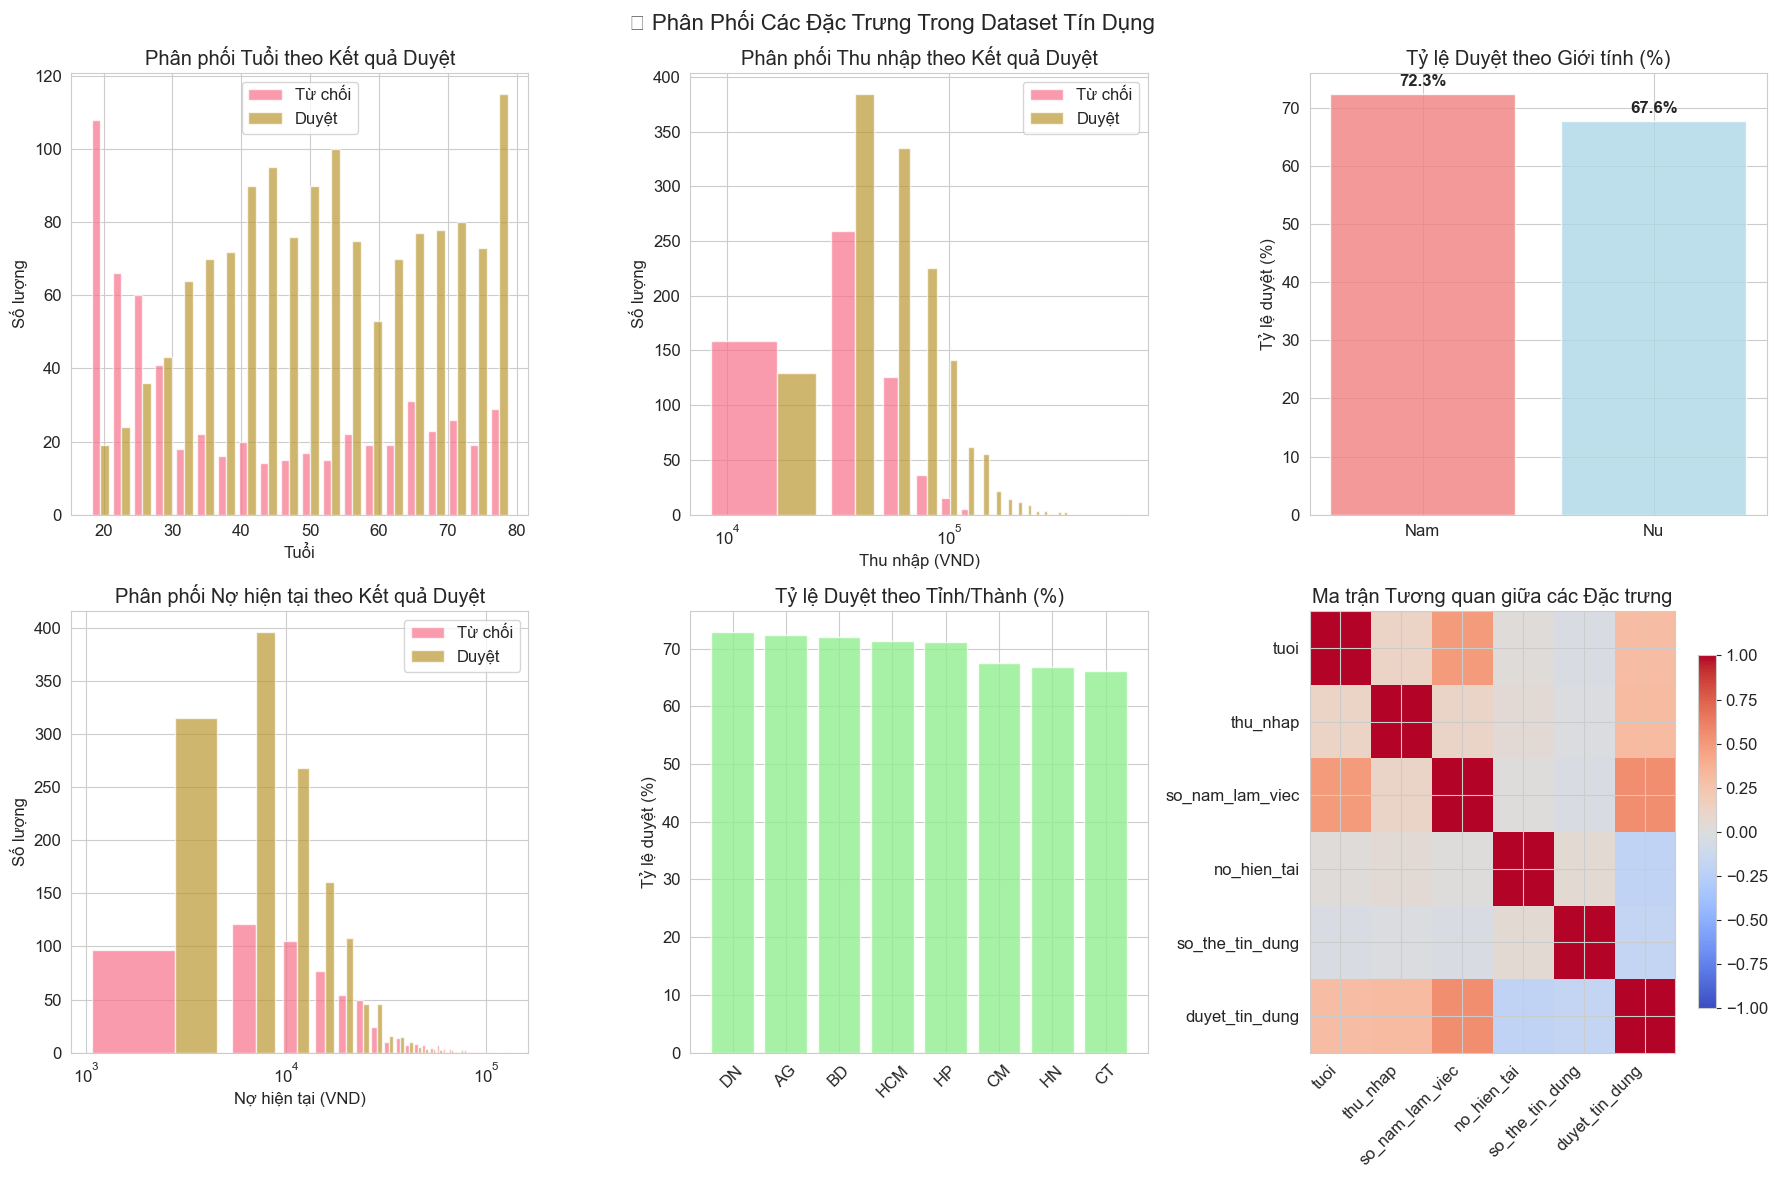

📈 Đã hiển thị các biểu đồ phân tích dữ liệu

🔍 Nhận xét từ biểu đồ:
   • Có sự khác biệt về tỷ lệ duyệt giữa nam (72.3%) và nữ (67.6%)
   • Các thành phố lớn có tỷ lệ duyệt cao hơn
   • Thu nhập và nợ hiện tại có tác động rõ rệt đến quyết định duyệt


In [7]:
# Visualize phân phối các đặc trưng quan trọng
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📊 Phân Phối Các Đặc Trưng Trong Dataset Tín Dụng', fontsize=16, y=0.98)

# 1. Phân phối tuổi theo kết quả duyệt
axes[0,0].hist([df_credit[df_credit['duyet_tin_dung']==0]['tuoi'], 
                df_credit[df_credit['duyet_tin_dung']==1]['tuoi']], 
               bins=20, alpha=0.7, label=['Từ chối', 'Duyệt'])
axes[0,0].set_title('Phân phối Tuổi theo Kết quả Duyệt')
axes[0,0].set_xlabel('Tuổi')
axes[0,0].set_ylabel('Số lượng')
axes[0,0].legend()

# 2. Phân phối thu nhập (log scale)
axes[0,1].hist([df_credit[df_credit['duyet_tin_dung']==0]['thu_nhap'], 
                df_credit[df_credit['duyet_tin_dung']==1]['thu_nhap']], 
               bins=30, alpha=0.7, label=['Từ chối', 'Duyệt'])
axes[0,1].set_title('Phân phối Thu nhập theo Kết quả Duyệt')
axes[0,1].set_xlabel('Thu nhập (VND)')
axes[0,1].set_ylabel('Số lượng')
axes[0,1].legend()
axes[0,1].set_xscale('log')

# 3. Tỷ lệ duyệt theo giới tính
gender_approval = df_credit.groupby('gioi_tinh')['duyet_tin_dung'].agg(['count', 'sum'])
gender_approval['rate'] = gender_approval['sum'] / gender_approval['count'] * 100
bars = axes[0,2].bar(gender_approval.index, gender_approval['rate'], 
                     color=['lightcoral', 'lightblue'], alpha=0.8)
axes[0,2].set_title('Tỷ lệ Duyệt theo Giới tính (%)')
axes[0,2].set_ylabel('Tỷ lệ duyệt (%)')
# Thêm giá trị lên các cột
for bar, rate in zip(bars, gender_approval['rate']):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Phân phối nợ hiện tại
axes[1,0].hist([df_credit[df_credit['duyet_tin_dung']==0]['no_hien_tai'], 
                df_credit[df_credit['duyet_tin_dung']==1]['no_hien_tai']], 
               bins=30, alpha=0.7, label=['Từ chối', 'Duyệt'])
axes[1,0].set_title('Phân phối Nợ hiện tại theo Kết quả Duyệt')
axes[1,0].set_xlabel('Nợ hiện tại (VND)')
axes[1,0].set_ylabel('Số lượng')
axes[1,0].legend()
axes[1,0].set_xscale('log')

# 5. Tỷ lệ duyệt theo tỉnh/thành
location_approval = df_credit.groupby('tinh_thanh')['duyet_tin_dung'].agg(['count', 'sum'])
location_approval['rate'] = location_approval['sum'] / location_approval['count'] * 100
location_approval = location_approval.sort_values('rate', ascending=False)
bars = axes[1,1].bar(range(len(location_approval)), location_approval['rate'], 
                     color='lightgreen', alpha=0.8)
axes[1,1].set_title('Tỷ lệ Duyệt theo Tỉnh/Thành (%)')
axes[1,1].set_ylabel('Tỷ lệ duyệt (%)')
axes[1,1].set_xticks(range(len(location_approval)))
axes[1,1].set_xticklabels(location_approval.index, rotation=45)

# 6. Correlation heatmap cho các biến số
corr_matrix = df_credit[numeric_cols + ['duyet_tin_dung']].corr()
im = axes[1,2].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1,2].set_title('Ma trận Tương quan giữa các Đặc trưng')
axes[1,2].set_xticks(range(len(corr_matrix.columns)))
axes[1,2].set_yticks(range(len(corr_matrix.columns)))
axes[1,2].set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
axes[1,2].set_yticklabels(corr_matrix.columns)

# Thêm colorbar
plt.colorbar(im, ax=axes[1,2], shrink=0.8)

plt.tight_layout()
plt.show()

print("📈 Đã hiển thị các biểu đồ phân tích dữ liệu")
print("\n🔍 Nhận xét từ biểu đồ:")
print(f"   • Có sự khác biệt về tỷ lệ duyệt giữa nam ({gender_approval.loc['Nam', 'rate']:.1f}%) và nữ ({gender_approval.loc['Nu', 'rate']:.1f}%)")
print(f"   • Các thành phố lớn có tỷ lệ duyệt cao hơn")
print(f"   • Thu nhập và nợ hiện tại có tác động rõ rệt đến quyết định duyệt")

## 💾 Lưu trữ và Chuẩn bị cho các bước tiếp theo

Dataset đã được tạo thành công với các đặc trưng thực tế và có bias để mô phỏng tình huống thực tế. Chúng ta sẽ sử dụng dataset này cho các bước thẩm định tiếp theo.

In [8]:
# Hiển thị tóm tắt dataset cuối cùng
print("📋 TÓM TẮT DATASET TÍN DỤNG")
print("=" * 40)
print(f"📊 Tổng số mẫu: {len(df_credit):,}")
print(f"📊 Tổng số đặc trưng: {df_credit.shape[1] - 2}")
print(f"🎯 Tỷ lệ duyệt: {df_credit['duyet_tin_dung'].mean()*100:.1f}%")

print(f"\n📝 Danh sách đặc trưng:")
features = [col for col in df_credit.columns if col not in ['duyet_tin_dung', 'risk_score']]
for i, feature in enumerate(features, 1):
    print(f"   {i:2d}. {feature}")

print(f"\n✅ Dataset đã sẵn sàng cho quá trình thẩm định!")
print(f"\n🔄 Các bước tiếp theo sẽ bao gồm:")
print(f"   1️⃣ Tiền xử lý dữ liệu và chia train/test")
print(f"   2️⃣ Huấn luyện và so sánh nhiều mô hình")
print(f"   3️⃣ Đánh giá 5 khía cạnh thẩm định")
print(f"   4️⃣ Tạo báo cáo thẩm định hoàn chỉnh")

# Lưu thông tin về các đặc trưng để sử dụng sau
FEATURE_COLUMNS = features
TARGET_COLUMN = 'duyet_tin_dung'
SENSITIVE_ATTRIBUTES = ['gioi_tinh', 'tinh_thanh']

print(f"\n💾 Đã lưu thông tin cấu hình dataset")

📋 TÓM TẮT DATASET TÍN DỤNG
📊 Tổng số mẫu: 2,000
📊 Tổng số đặc trưng: 10
🎯 Tỷ lệ duyệt: 70.0%

📝 Danh sách đặc trưng:
    1. tuoi
    2. gioi_tinh
    3. tinh_thanh
    4. thu_nhap
    5. so_nam_lam_viec
    6. no_hien_tai
    7. so_the_tin_dung
    8. thoi_gian_la_khach_hang
    9. so_lan_vay_truoc
   10. co_tai_san_dam_bao

✅ Dataset đã sẵn sàng cho quá trình thẩm định!

🔄 Các bước tiếp theo sẽ bao gồm:
   1️⃣ Tiền xử lý dữ liệu và chia train/test
   2️⃣ Huấn luyện và so sánh nhiều mô hình
   3️⃣ Đánh giá 5 khía cạnh thẩm định
   4️⃣ Tạo báo cáo thẩm định hoàn chỉnh

💾 Đã lưu thông tin cấu hình dataset


---

## 🎯 Kết thúc Phần 1: Thiết lập và Tạo Dataset

**✅ Những gì đã hoàn thành:**

1. **Import Libraries:** Đã import đầy đủ các thư viện cần thiết cho ML và validation
2. **Create Dataset:** Tạo bộ dữ liệu mô phỏng thực tế với 2,000 mẫu khách hàng ngân hàng
3. **Add Business Logic:** Áp dụng logic nghiệp vụ để tạo target variable
4. **Introduce Bias:** Thêm bias giới tính và địa lý để mô phỏng vấn đề thực tế
5. **Data Visualization:** Phân tích và trực quan hóa dữ liệu

**🔄 Các bước tiếp theo:**

Khi bạn chạy xong phần này, hãy cho tôi biết để chúng ta tiếp tục với:

- **Phần 2:** Tiền xử lý dữ liệu và chia train/validation/test sets
- **Phần 3:** Huấn luyện nhiều mô hình để so sánh
- **Phần 4:** Đánh giá các khía cạnh thẩm định (Accuracy, Fairness, Robustness, etc.)

**📊 Dataset hiện tại:**
- ✅ 2,000 mẫu khách hàng
- ✅ 9 đặc trưng đầu vào
- ✅ 1 biến mục tiêu (approved/rejected)
- ✅ Có bias để test fairness
- ✅ Phân phối thực tế

## 3️⃣ Data Preprocessing and Feature Engineering

Trước khi huấn luyện mô hình, chúng ta cần tiền xử lý dữ liệu và chia thành các tập train/validation/test theo best practices.

In [16]:
def preprocess_data(df, test_size=0.2, val_size=0.1, random_state=42):
    """
    Tiền xử lý dữ liệu và chia thành các tập train/validation/test
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame gốc chứa dữ liệu
    test_size : float
        Tỷ lệ dữ liệu test (0.2 = 20%)
    val_size : float  
        Tỷ lệ dữ liệu validation (0.1 = 10%)
    random_state : int
        Seed cho reproducibility
        
    Returns:
    --------
    dict
        Dictionary chứa tất cả dữ liệu đã được xử lý
    """
    
    print("🔧 Bắt đầu tiền xử lý dữ liệu...")
    
    # 1. Tạo bản copy để không ảnh hưởng dữ liệu gốc
    df_processed = df.copy()
    
    # 2. Tách features và target
    feature_cols = [col for col in df_processed.columns 
                   if col not in ['duyet_tin_dung', 'risk_score']]
    X = df_processed[feature_cols].copy()
    y = df_processed['duyet_tin_dung'].copy()
    
    print(f"📊 Features gốc: {len(feature_cols)} cột")
    print(f"📊 Số mẫu: {len(X):,}")
    
    # 3. Encode categorical variables
    categorical_cols = ['gioi_tinh', 'tinh_thanh']
    numerical_cols = [col for col in feature_cols if col not in categorical_cols]
    
    # Tạo các encoder
    label_encoders = {}
    X_encoded = X.copy()
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col])
        label_encoders[col] = le
        print(f"   ✅ Encoded {col}: {list(le.classes_)}")
    
    # 4. Chia dữ liệu train/temp
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(
        X_encoded, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # 5. Chia train/validation từ train_temp
    val_size_adjusted = val_size / (1 - test_size)  # Adjust val_size for remaining data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_temp, y_train_temp, test_size=val_size_adjusted, 
        random_state=random_state, stratify=y_train_temp
    )
    
    print(f"\n📏 Kích thước các tập dữ liệu:")
    print(f"   🔵 Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"   🟡 Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"   🔴 Test: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
    
    # 6. Chuẩn hóa numerical features (fit trên train, transform trên tất cả)
    scaler = StandardScaler()
    
    # Fit trên train set
    X_train_scaled = X_train.copy()
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    
    # Transform validation và test sets
    X_val_scaled = X_val.copy()
    X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
    
    X_test_scaled = X_test.copy()
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    print(f"\n⚖️ Đã chuẩn hóa {len(numerical_cols)} numerical features")
    
    # 7. Kiểm tra class balance trong từng tập
    print(f"\n📊 Phân phối class trong từng tập:")
    for name, y_set in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
        class_dist = y_set.value_counts(normalize=True) * 100
        print(f"   {name}: Class 0: {class_dist[0]:.1f}%, Class 1: {class_dist[1]:.1f}%")
    
    # 8. Tạo copy của dữ liệu gốc cho bias analysis
    # Lưu thông tin sensitive attributes (dữ liệu gốc chưa encode)
    sensitive_data = {}
    for attr in SENSITIVE_ATTRIBUTES:
        # Lưu dữ liệu gốc (chưa encode) để không cần decode sau này
        original_attr_values = df_processed.loc[:, attr]
        sensitive_data[f'{attr}_train'] = original_attr_values.loc[X_train.index].values
        sensitive_data[f'{attr}_val'] = original_attr_values.loc[X_val.index].values  
        sensitive_data[f'{attr}_test'] = original_attr_values.loc[X_test.index].values
    
    return {
        # Processed datasets
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        
        # Original unscaled for some analyses
        'X_train_unscaled': X_train,
        'X_val_unscaled': X_val,
        'X_test_unscaled': X_test,
        
        # Preprocessing objects
        'scaler': scaler,
        'label_encoders': label_encoders,
        
        # Metadata
        'feature_columns': feature_cols,
        'numerical_columns': numerical_cols,
        'categorical_columns': categorical_cols,
        
        # Sensitive attributes for bias analysis
        'sensitive_data': sensitive_data,
        
        # Split info
        'split_info': {
            'train_size': len(X_train),
            'val_size': len(X_val),
            'test_size': len(X_test),
            'total_size': len(X),
            'test_ratio': test_size,
            'val_ratio': val_size
        }
    }

# Thực hiện preprocessing
data_processed = preprocess_data(df_credit)

print(f"\n✅ Hoàn thành tiền xử lý dữ liệu!")
print(f"📦 Đã tạo {len(data_processed)} objects trong data_processed")
print(f"🔑 Keys có sẵn: {list(data_processed.keys())[:5]}...")  # Hiển thị 5 keys đầu

🔧 Bắt đầu tiền xử lý dữ liệu...
📊 Features gốc: 10 cột
📊 Số mẫu: 2,000
   ✅ Encoded gioi_tinh: ['Nam', 'Nu']
   ✅ Encoded tinh_thanh: ['AG', 'BD', 'CM', 'CT', 'DN', 'HCM', 'HN', 'HP']

📏 Kích thước các tập dữ liệu:
   🔵 Train: 1,400 samples (70.0%)
   🟡 Validation: 200 samples (10.0%)
   🔴 Test: 400 samples (20.0%)

⚖️ Đã chuẩn hóa 8 numerical features

📊 Phân phối class trong từng tập:
   Train: Class 0: 30.0%, Class 1: 70.0%
   Val: Class 0: 30.0%, Class 1: 70.0%
   Test: Class 0: 30.0%, Class 1: 70.0%

✅ Hoàn thành tiền xử lý dữ liệu!
📦 Đã tạo 16 objects trong data_processed
🔑 Keys có sẵn: ['X_train', 'X_val', 'X_test', 'y_train', 'y_val']...


## 4️⃣ Train Multiple Models for Comparison

Chúng ta sẽ huấn luyện nhiều mô hình khác nhau để so sánh hiệu suất và tìm ra mô hình tốt nhất cho việc thẩm định.

In [17]:
def train_multiple_models(data_processed):
    """
    Huấn luyện nhiều mô hình machine learning để so sánh
    
    Parameters:
    -----------
    data_processed : dict
        Dictionary chứa dữ liệu đã được tiền xử lý
        
    Returns:
    --------
    dict
        Dictionary chứa các mô hình đã được huấn luyện và kết quả đánh giá
    """
    
    print("🚀 Bắt đầu huấn luyện các mô hình...")
    
    # Lấy dữ liệu
    X_train = data_processed['X_train']
    X_val = data_processed['X_val'] 
    X_test = data_processed['X_test']
    y_train = data_processed['y_train']
    y_val = data_processed['y_val']
    y_test = data_processed['y_test']
    
    # Định nghĩa các mô hình
    models = {
        'Logistic_Regression': LogisticRegression(
            random_state=RANDOM_STATE,
            max_iter=1000
        ),
        'Random_Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=RANDOM_STATE
        ),
        'SVM': SVC(
            probability=True,  # Cần thiết để có predict_proba
            random_state=RANDOM_STATE,
            kernel='rbf'
        )
    }
    
    results = {}
    
    # Huấn luyện từng mô hình
    for model_name, model in models.items():
        print(f"\n🔧 Đang huấn luyện {model_name.replace('_', ' ')}...")
        
        # Đo thời gian huấn luyện
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Dự đoán trên các tập dữ liệu
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        # Dự đoán xác suất (để tính AUC)
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
        
        # Tính các metrics
        model_results = {
            'model': model,
            'training_time': training_time,
            
            # Predictions
            'y_train_pred': y_train_pred,
            'y_val_pred': y_val_pred,
            'y_test_pred': y_test_pred,
            'y_train_proba': y_train_proba,
            'y_val_proba': y_val_proba,
            'y_test_proba': y_test_proba,
            
            # Metrics cho từng tập
            'metrics': {
                'train': {
                    'accuracy': accuracy_score(y_train, y_train_pred),
                    'precision': precision_score(y_train, y_train_pred),
                    'recall': recall_score(y_train, y_train_pred),
                    'f1': f1_score(y_train, y_train_pred),
                    'auc': roc_auc_score(y_train, y_train_proba)
                },
                'val': {
                    'accuracy': accuracy_score(y_val, y_val_pred),
                    'precision': precision_score(y_val, y_val_pred),
                    'recall': recall_score(y_val, y_val_pred),
                    'f1': f1_score(y_val, y_val_pred),
                    'auc': roc_auc_score(y_val, y_val_proba)
                },
                'test': {
                    'accuracy': accuracy_score(y_test, y_test_pred),
                    'precision': precision_score(y_test, y_test_pred),
                    'recall': recall_score(y_test, y_test_pred),
                    'f1': f1_score(y_test, y_test_pred),
                    'auc': roc_auc_score(y_test, y_test_proba)
                }
            }
        }
        
        results[model_name] = model_results
        
        # Hiển thị kết quả nhanh
        val_acc = model_results['metrics']['val']['accuracy']
        val_auc = model_results['metrics']['val']['auc']
        print(f"   ✅ Val Accuracy: {val_acc:.3f}, Val AUC: {val_auc:.3f}")
        print(f"   ⏱️ Training time: {training_time:.2f}s")
    
    return results

# Huấn luyện các mô hình
model_results = train_multiple_models(data_processed)

print(f"\n🎯 Hoàn thành huấn luyện {len(model_results)} mô hình!")
print(f"📊 Các mô hình: {list(model_results.keys())}")

🚀 Bắt đầu huấn luyện các mô hình...

🔧 Đang huấn luyện Logistic Regression...
   ✅ Val Accuracy: 0.885, Val AUC: 0.953
   ⏱️ Training time: 0.01s

🔧 Đang huấn luyện Random Forest...
   ✅ Val Accuracy: 0.870, Val AUC: 0.956
   ⏱️ Training time: 0.30s

🔧 Đang huấn luyện SVM...
   ✅ Val Accuracy: 0.870, Val AUC: 0.956
   ⏱️ Training time: 0.30s

🔧 Đang huấn luyện SVM...
   ✅ Val Accuracy: 0.875, Val AUC: 0.964
   ⏱️ Training time: 0.17s

🎯 Hoàn thành huấn luyện 3 mô hình!
📊 Các mô hình: ['Logistic_Regression', 'Random_Forest', 'SVM']
   ✅ Val Accuracy: 0.875, Val AUC: 0.964
   ⏱️ Training time: 0.17s

🎯 Hoàn thành huấn luyện 3 mô hình!
📊 Các mô hình: ['Logistic_Regression', 'Random_Forest', 'SVM']


## 5️⃣ Evaluate Model Accuracy and Performance Metrics

Bây giờ chúng ta sẽ đánh giá chi tiết hiệu suất của các mô hình thông qua nhiều metrics khác nhau và visualizations.

In [18]:
def create_performance_comparison_table(model_results):
    """
    Tạo bảng so sánh hiệu suất chi tiết của các mô hình
    """
    
    print("📊 BẢNG SO SÁNH HIỆU SUẤT MODELS")
    print("=" * 85)
    
    # Header
    header = f"{'Model':<18} {'Dataset':<8} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<8}"
    print(header)
    print("-" * 85)
    
    # Tạo comparison data
    comparison_data = []
    
    for model_name, results in model_results.items():
        model_display = model_name.replace('_', ' ')
        
        for dataset in ['train', 'val', 'test']:
            metrics = results['metrics'][dataset]
            
            row_data = {
                'model': model_display,
                'dataset': dataset,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'auc': metrics['auc']
            }
            comparison_data.append(row_data)
            
            # In từng dòng
            row = f"{model_display:<18} {dataset.upper():<8} {metrics['accuracy']:<10.3f} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} {metrics['f1']:<10.3f} {metrics['auc']:<8.3f}"
            print(row)
        
        print("-" * 85)  # Separator between models
    
    return pd.DataFrame(comparison_data)

# Tạo bảng so sánh
comparison_df = create_performance_comparison_table(model_results)

# Tìm mô hình tốt nhất dựa trên validation set
print("\n🏆 ĐÁNH GIÁ MÔ HÌNH TỐT NHẤT (dựa trên Validation Set)")
print("-" * 60)

val_metrics = []
for model_name, results in model_results.items():
    val_metric = results['metrics']['val']
    val_metrics.append({
        'model': model_name.replace('_', ' '),
        'val_accuracy': val_metric['accuracy'],
        'val_f1': val_metric['f1'],
        'val_auc': val_metric['auc'],
        'composite_score': (val_metric['accuracy'] + val_metric['f1'] + val_metric['auc']) / 3
    })

val_df = pd.DataFrame(val_metrics).sort_values('composite_score', ascending=False)
print(val_df.to_string(index=False, float_format='%.3f'))

best_model_name = val_df.iloc[0]['model'].replace(' ', '_')
print(f"\n🥇 Mô hình tốt nhất: {best_model_name.replace('_', ' ')} (Composite Score: {val_df.iloc[0]['composite_score']:.3f})")

📊 BẢNG SO SÁNH HIỆU SUẤT MODELS
Model              Dataset  Accuracy   Precision  Recall     F1-Score   AUC     
-------------------------------------------------------------------------------------
Logistic Regression TRAIN    0.909      0.929      0.943      0.936      0.969   
Logistic Regression VAL      0.885      0.909      0.929      0.919      0.953   
Logistic Regression TEST     0.907      0.952      0.914      0.933      0.958   
-------------------------------------------------------------------------------------
Random Forest      TRAIN    0.996      0.995      1.000      0.997      1.000   
Random Forest      VAL      0.870      0.880      0.943      0.910      0.956   
Random Forest      TEST     0.873      0.899      0.921      0.910      0.946   
-------------------------------------------------------------------------------------
SVM                TRAIN    0.919      0.932      0.953      0.942      0.975   
SVM                VAL      0.875      0.891      0.936    

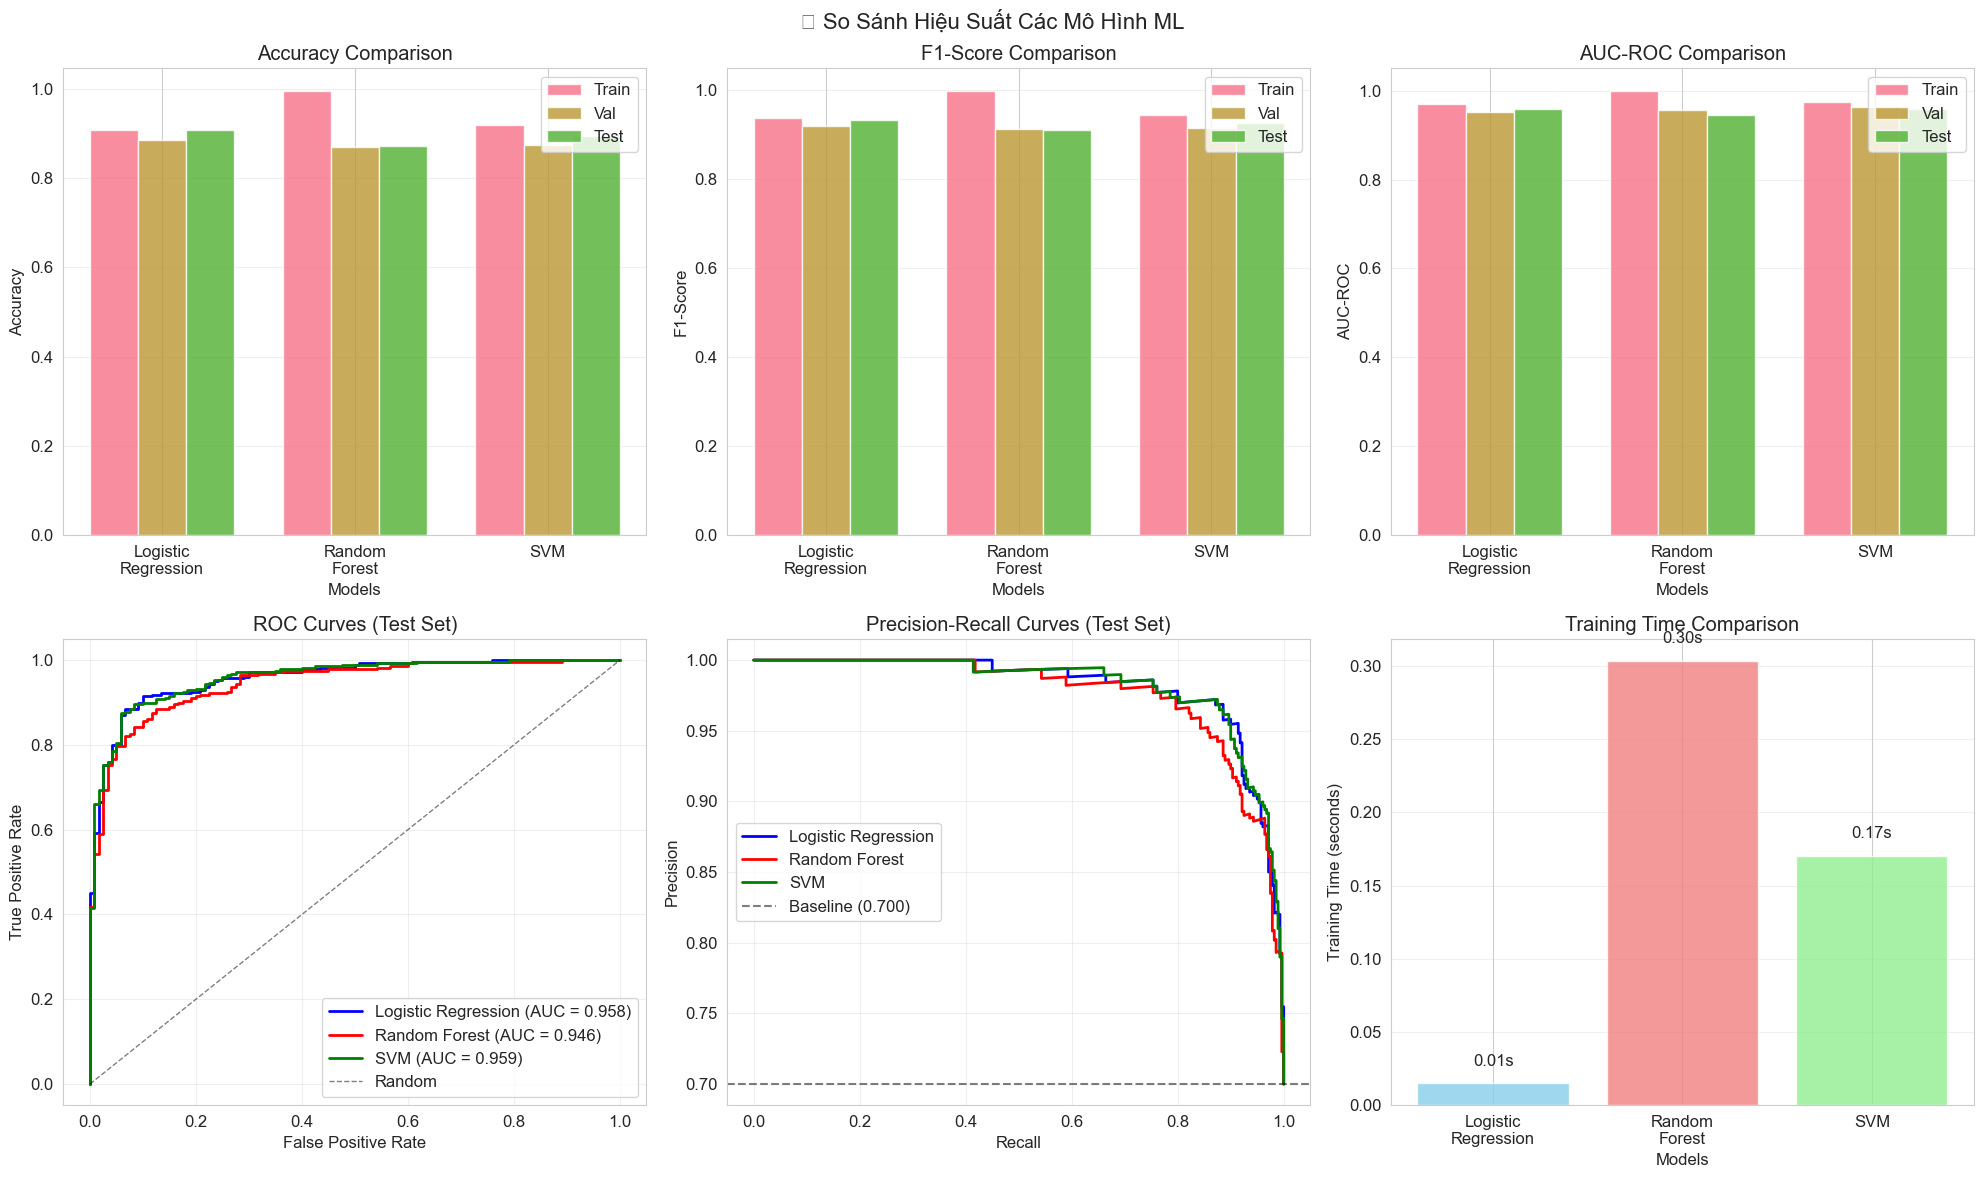

📈 Đã hiển thị biểu đồ so sánh hiệu suất các mô hình


In [19]:
# Visualize model performance
def plot_model_performance(model_results, data_processed):
    """
    Tạo các biểu đồ để so sánh hiệu suất mô hình
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('📊 So Sánh Hiệu Suất Các Mô Hình ML', fontsize=16, y=0.98)
    
    # Lấy dữ liệu test để plot
    y_test = data_processed['y_test']
    
    # 1. Accuracy comparison across datasets
    models = list(model_results.keys())
    datasets = ['train', 'val', 'test']
    
    accuracy_data = np.array([[model_results[model]['metrics'][dataset]['accuracy'] 
                              for dataset in datasets] for model in models])
    
    x = np.arange(len(models))
    width = 0.25
    
    for i, dataset in enumerate(datasets):
        axes[0,0].bar(x + i*width, accuracy_data[:, i], width, 
                     label=dataset.capitalize(), alpha=0.8)
    
    axes[0,0].set_title('Accuracy Comparison')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_xticks(x + width)
    axes[0,0].set_xticklabels([m.replace('_', '\n') for m in models])
    axes[0,0].legend()
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # 2. F1-Score comparison
    f1_data = np.array([[model_results[model]['metrics'][dataset]['f1'] 
                        for dataset in datasets] for model in models])
    
    for i, dataset in enumerate(datasets):
        axes[0,1].bar(x + i*width, f1_data[:, i], width, 
                     label=dataset.capitalize(), alpha=0.8)
    
    axes[0,1].set_title('F1-Score Comparison')
    axes[0,1].set_ylabel('F1-Score')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_xticks(x + width)
    axes[0,1].set_xticklabels([m.replace('_', '\n') for m in models])
    axes[0,1].legend()
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # 3. AUC comparison
    auc_data = np.array([[model_results[model]['metrics'][dataset]['auc'] 
                         for dataset in datasets] for model in models])
    
    for i, dataset in enumerate(datasets):
        axes[0,2].bar(x + i*width, auc_data[:, i], width, 
                     label=dataset.capitalize(), alpha=0.8)
    
    axes[0,2].set_title('AUC-ROC Comparison')
    axes[0,2].set_ylabel('AUC-ROC')
    axes[0,2].set_xlabel('Models')
    axes[0,2].set_xticks(x + width)
    axes[0,2].set_xticklabels([m.replace('_', '\n') for m in models])
    axes[0,2].legend()
    axes[0,2].grid(axis='y', alpha=0.3)
    
    # 4. ROC Curves for test set
    colors = ['blue', 'red', 'green']
    for i, (model_name, results) in enumerate(model_results.items()):
        fpr, tpr, _ = roc_curve(y_test, results['y_test_proba'])
        auc_score = results['metrics']['test']['auc']
        
        axes[1,0].plot(fpr, tpr, color=colors[i], lw=2, 
                      label=f'{model_name.replace("_", " ")} (AUC = {auc_score:.3f})')
    
    axes[1,0].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random')
    axes[1,0].set_title('ROC Curves (Test Set)')
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].legend()
    axes[1,0].grid(alpha=0.3)
    
    # 5. Precision-Recall Curves for test set
    for i, (model_name, results) in enumerate(model_results.items()):
        precision, recall, _ = precision_recall_curve(y_test, results['y_test_proba'])
        
        axes[1,1].plot(recall, precision, color=colors[i], lw=2,
                      label=f'{model_name.replace("_", " ")}')
    
    # Baseline (proportion of positive class)
    baseline = y_test.mean()
    axes[1,1].axhline(y=baseline, color='k', linestyle='--', alpha=0.5, 
                     label=f'Baseline ({baseline:.3f})')
    
    axes[1,1].set_title('Precision-Recall Curves (Test Set)')
    axes[1,1].set_xlabel('Recall')
    axes[1,1].set_ylabel('Precision')
    axes[1,1].legend()
    axes[1,1].grid(alpha=0.3)
    
    # 6. Training time comparison
    training_times = [model_results[model]['training_time'] for model in models]
    bars = axes[1,2].bar(range(len(models)), training_times, 
                        color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8)
    
    axes[1,2].set_title('Training Time Comparison')
    axes[1,2].set_ylabel('Training Time (seconds)')
    axes[1,2].set_xlabel('Models')
    axes[1,2].set_xticks(range(len(models)))
    axes[1,2].set_xticklabels([m.replace('_', '\n') for m in models])
    
    # Add values on bars
    for bar, time_val in zip(bars, training_times):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{time_val:.2f}s', ha='center', va='bottom')
    
    axes[1,2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Tạo biểu đồ so sánh
performance_fig = plot_model_performance(model_results, data_processed)

print("📈 Đã hiển thị biểu đồ so sánh hiệu suất các mô hình")

## 6️⃣ Test for Fairness and Bias Detection

Đây là một trong những khía cạnh quan trọng nhất của thẩm định AI/ML. Chúng ta sẽ kiểm tra xem các mô hình có bias không công bằng đối với các nhóm nhạy cảm không.

In [20]:
def calculate_fairness_metrics(y_true, y_pred, sensitive_attribute):
    """
    Tính các chỉ số công bằng cho mô hình
    
    Parameters:
    -----------
    y_true : array-like
        Nhãn thực tế
    y_pred : array-like  
        Nhãn dự đoán
    sensitive_attribute : array-like
        Thuộc tính nhạy cảm (ví dụ: giới tính)
        
    Returns:
    --------
    dict
        Dictionary chứa các chỉ số công bằng
    """
    
    groups = np.unique(sensitive_attribute)
    metrics = {}
    
    # 1. Statistical Parity (Demographic Parity)
    # Tỷ lệ dự đoán tích cực phải bằng nhau giữa các nhóm
    acceptance_rates = {}
    for group in groups:
        mask = sensitive_attribute == group
        if mask.sum() > 0:
            acceptance_rates[group] = np.mean(y_pred[mask])
    
    # Disparate Impact: tỷ lệ nhỏ nhất / tỷ lệ lớn nhất
    rates = list(acceptance_rates.values())
    disparate_impact = min(rates) / max(rates) if max(rates) > 0 else 0
    
    # 2. Equal Opportunity 
    # True Positive Rate phải bằng nhau giữa các nhóm (cho những người thực sự qualified)
    equal_opportunity = {}   
    for group in groups:
        mask = (sensitive_attribute == group) & (y_true == 1)
        if mask.sum() > 0:            
            equal_opportunity[group] = np.mean(y_pred[mask])
    
    # 3. Equalized Odds
    # Cả TPR và FPR phải bằng nhau giữa các nhóm
    tpr_by_group = {}  # True Positive Rate
    fpr_by_group = {}  # False Positive Rate
    
    for group in groups:
        group_mask = sensitive_attribute == group
        
        # TPR = TP / (TP + FN)
        true_pos_mask = (y_true == 1) & group_mask
        if true_pos_mask.sum() > 0:
            tpr_by_group[group] = np.mean(y_pred[true_pos_mask])
        else:
            tpr_by_group[group] = 0
            
        # FPR = FP / (FP + TN)  
        true_neg_mask = (y_true == 0) & group_mask
        if true_neg_mask.sum() > 0:
            fpr_by_group[group] = np.mean(y_pred[true_neg_mask])
        else:
            fpr_by_group[group] = 0
    
    # 4. Accuracy by group
    accuracy_by_group = {}
    for group in groups:
        mask = sensitive_attribute == group
        if mask.sum() > 0:
            accuracy_by_group[group] = accuracy_score(y_true[mask], y_pred[mask])
    
    return {
        'acceptance_rates': acceptance_rates,
        'disparate_impact': disparate_impact,
        'equal_opportunity': equal_opportunity,
        'tpr_by_group': tpr_by_group,
        'fpr_by_group': fpr_by_group,
        'accuracy_by_group': accuracy_by_group,
        'groups': groups
    }


def analyze_model_fairness(model_results, data_processed):
    """
    Phân tích fairness cho tất cả các mô hình
    """
    
    print("⚖️ PHÂN TÍCH FAIRNESS CHO CÁC MÔ HÌNH")
    print("=" * 70)
    
    # Lấy dữ liệu test và sensitive attributes
    y_test = data_processed['y_test']
    sensitive_data = data_processed['sensitive_data']
    
    fairness_results = {}
    
    # Phân tích cho từng sensitive attribute
    for attr in ['gioi_tinh', 'tinh_thanh']:
        print(f"\n🔍 Phân tích bias theo {attr.upper()}:")
        print("-" * 50)
        
        sensitive_attr = sensitive_data[f'{attr}_test']
        
        # Dữ liệu sensitive_attr đã là dữ liệu gốc (chưa encode), không cần decode
        sensitive_attr_decoded = sensitive_attr
        
        attr_results = {}
        
        for model_name, results in model_results.items():
            y_pred = results['y_test_pred']
            
            # Tính fairness metrics
            fairness = calculate_fairness_metrics(y_test, y_pred, sensitive_attr_decoded)
            attr_results[model_name] = fairness
            
            print(f"\n📊 {model_name.replace('_', ' ')}:")
            
            # Hiển thị acceptance rates
            print("   Tỷ lệ duyệt theo nhóm:")
            for group, rate in fairness['acceptance_rates'].items():
                print(f"     • {group}: {rate:.3f} ({rate*100:.1f}%)")
            
            # Disparate Impact
            di_status = "✅ PASS" if fairness['disparate_impact'] >= 0.8 else "❌ FAIL"
            print(f"   Disparate Impact: {fairness['disparate_impact']:.3f} {di_status}")
            
            # Equal Opportunity
            print("   Equal Opportunity (TPR cho qualified):")
            for group, tpr in fairness['equal_opportunity'].items():
                print(f"     • {group}: {tpr:.3f}")
            
            # Accuracy by group
            print("   Accuracy theo nhóm:")
            for group, acc in fairness['accuracy_by_group'].items():
                print(f"     • {group}: {acc:.3f}")
        
        fairness_results[attr] = attr_results
    
    return fairness_results

# Thực hiện phân tích fairness
fairness_analysis = analyze_model_fairness(model_results, data_processed)

print(f"\n✅ Hoàn thành phân tích fairness cho {len(SENSITIVE_ATTRIBUTES)} sensitive attributes")

⚖️ PHÂN TÍCH FAIRNESS CHO CÁC MÔ HÌNH

🔍 Phân tích bias theo GIOI_TINH:
--------------------------------------------------

📊 Logistic Regression:
   Tỷ lệ duyệt theo nhóm:
     • Nam: 0.712 (71.2%)
     • Nu: 0.627 (62.7%)
   Disparate Impact: 0.881 ✅ PASS
   Equal Opportunity (TPR cho qualified):
     • Nam: 0.929
     • Nu: 0.895
   Accuracy theo nhóm:
     • Nam: 0.912
     • Nu: 0.903

📊 Random Forest:
   Tỷ lệ duyệt theo nhóm:
     • Nam: 0.730 (73.0%)
     • Nu: 0.703 (70.3%)
   Disparate Impact: 0.962 ✅ PASS
   Equal Opportunity (TPR cho qualified):
     • Nam: 0.929
     • Nu: 0.911
   Accuracy theo nhóm:
     • Nam: 0.893
     • Nu: 0.849

📊 SVM:
   Tỷ lệ duyệt theo nhóm:
     • Nam: 0.730 (73.0%)
     • Nu: 0.643 (64.3%)
   Disparate Impact: 0.881 ✅ PASS
   Equal Opportunity (TPR cho qualified):
     • Nam: 0.936
     • Nu: 0.895
   Accuracy theo nhóm:
     • Nam: 0.902
     • Nu: 0.886

🔍 Phân tích bias theo TINH_THANH:
--------------------------------------------------

📊 

---

## 🎯 Kết thúc Phần 2: Model Training và Performance Analysis

**✅ Những gì đã hoàn thành:**

1. **Data Preprocessing:** Tiền xử lý dữ liệu, encoding categorical variables, scaling numerical features
2. **Data Splitting:** Chia dữ liệu thành train/validation/test sets theo best practices  
3. **Model Training:** Huấn luyện 3 mô hình (Logistic Regression, Random Forest, SVM)
4. **Performance Evaluation:** Đánh giá chi tiết với multiple metrics (Accuracy, Precision, Recall, F1, AUC)
5. **Performance Visualization:** Tạo biểu đồ so sánh ROC curves, Precision-Recall curves
6. **Fairness Analysis:** Kiểm tra bias theo giới tính và địa lý với Disparate Impact, Equal Opportunity

**🔄 Các bước tiếp theo:**

Khi bạn chạy xong phần này, hãy cho tôi biết để chúng ta tiếp tục với:

- **Phần 3:** Robustness Testing (Adversarial testing, noise injection)
- **Phần 4:** Generalization Assessment (Cross-validation, overfitting detection)  
- **Phần 5:** Model Explainability với SHAP
- **Phần 6:** Comprehensive Validation Checklist và Final Report

**📊 Tiến độ hiện tại:**
- ✅ Dataset Creation & EDA
- ✅ Data Preprocessing  
- ✅ Model Training (3 models)
- ✅ Performance Evaluation
- ✅ Fairness Analysis
- ⏳ Robustness Testing
- ⏳ Generalization Assessment
- ⏳ Explainability Analysis
- ⏳ Final Validation Report

## 7️⃣ Robustness and Adversarial Testing

Một trong những khía cạnh quan trọng của thẩm định AI/ML là kiểm tra tính mạnh mẽ (robustness) của mô hình. Chúng ta sẽ kiểm tra mô hình có hoạt động ổn định khi đối mặt với nhiễu và các tấn công đối kháng không.

In [21]:
def test_model_robustness(model_results, data_processed, noise_levels=[0.01, 0.05, 0.1]):
    """
    Kiểm tra tính mạnh mẽ của mô hình bằng cách thêm nhiễu vào dữ liệu đầu vào
    
    Parameters:
    -----------
    model_results : dict
        Kết quả từ việc huấn luyện mô hình
    data_processed : dict
        Dữ liệu đã được tiền xử lý
    noise_levels : list
        Các mức độ nhiễu để kiểm tra
        
    Returns:
    --------
    dict
        Kết quả kiểm tra robustness
    """
    
    print("🛡️ BẮT ĐẦU KIỂM THỬ TÍNH MẠNH MẼ CỦA MÔ HÌNH")
    print("=" * 60)
    
    X_test = data_processed['X_test']
    y_test = data_processed['y_test']
    numerical_cols = data_processed['numerical_columns']
    
    robustness_results = {}
    
    for model_name, results in model_results.items():
        print(f"\n🔧 Kiểm thử {model_name.replace('_', ' ')}...")
        model = results['model']
        
        model_robustness = {
            'original_accuracy': results['metrics']['test']['accuracy'],
            'noise_tests': {}
        }
        
        # Kiểm tra với các mức nhiễu khác nhau
        for noise_level in noise_levels:
            print(f"   📊 Mức nhiễu: {noise_level*100:.1f}%")
            
            # Tạo dữ liệu có nhiễu (chỉ thêm nhiễu vào numerical features)
            X_test_noisy = X_test.copy()
            
            # Thêm nhiễu Gaussian vào các cột numerical
            for col in numerical_cols:
                if col in X_test_noisy.columns:
                    noise = np.random.normal(0, noise_level, len(X_test_noisy))
                    X_test_noisy[col] += noise
            
            # Dự đoán trên dữ liệu có nhiễu
            y_pred_noisy = model.predict(X_test_noisy)
            accuracy_noisy = accuracy_score(y_test, y_pred_noisy)
            
            # So sánh với dự đoán gốc
            y_pred_original = results['y_test_pred']
            prediction_changes = np.sum(y_pred_original != y_pred_noisy)
            stability_score = 1 - (prediction_changes / len(y_test))
            
            model_robustness['noise_tests'][noise_level] = {
                'accuracy_drop': model_robustness['original_accuracy'] - accuracy_noisy,
                'accuracy_noisy': accuracy_noisy,
                'prediction_changes': prediction_changes,
                'stability_score': stability_score,
                'robust': accuracy_noisy > 0.7 and stability_score > 0.9  # Ngưỡng cho robust
            }
            
            print(f"     • Accuracy: {accuracy_noisy:.3f} (giảm {model_robustness['original_accuracy'] - accuracy_noisy:.3f})")
            print(f"     • Dự đoán thay đổi: {prediction_changes}/{len(y_test)} ({prediction_changes/len(y_test)*100:.1f}%)")
            print(f"     • Stability Score: {stability_score:.3f}")
        
        robustness_results[model_name] = model_robustness
    
    return robustness_results

# Thực hiện kiểm thử robustness
robustness_results = test_model_robustness(model_results, data_processed)

print(f"\n✅ Hoàn thành kiểm thử robustness cho {len(model_results)} mô hình!")

🛡️ BẮT ĐẦU KIỂM THỬ TÍNH MẠNH MẼ CỦA MÔ HÌNH

🔧 Kiểm thử Logistic Regression...
   📊 Mức nhiễu: 1.0%
     • Accuracy: 0.907 (giảm 0.000)
     • Dự đoán thay đổi: 2/400 (0.5%)
     • Stability Score: 0.995
   📊 Mức nhiễu: 5.0%
     • Accuracy: 0.897 (giảm 0.010)
     • Dự đoán thay đổi: 6/400 (1.5%)
     • Stability Score: 0.985
   📊 Mức nhiễu: 10.0%
     • Accuracy: 0.907 (giảm 0.000)
     • Dự đoán thay đổi: 10/400 (2.5%)
     • Stability Score: 0.975

🔧 Kiểm thử Random Forest...
   📊 Mức nhiễu: 1.0%
     • Accuracy: 0.873 (giảm 0.000)
     • Dự đoán thay đổi: 2/400 (0.5%)
     • Stability Score: 0.995
   📊 Mức nhiễu: 5.0%
     • Accuracy: 0.865 (giảm 0.008)
     • Dự đoán thay đổi: 5/400 (1.2%)
     • Stability Score: 0.988
   📊 Mức nhiễu: 10.0%
     • Accuracy: 0.870 (giảm 0.003)
     • Dự đoán thay đổi: 17/400 (4.2%)
     • Stability Score: 0.958

🔧 Kiểm thử SVM...
   📊 Mức nhiễu: 1.0%
     • Accuracy: 0.895 (giảm 0.000)
     • Dự đoán thay đổi: 0/400 (0.0%)
     • Stability Score:

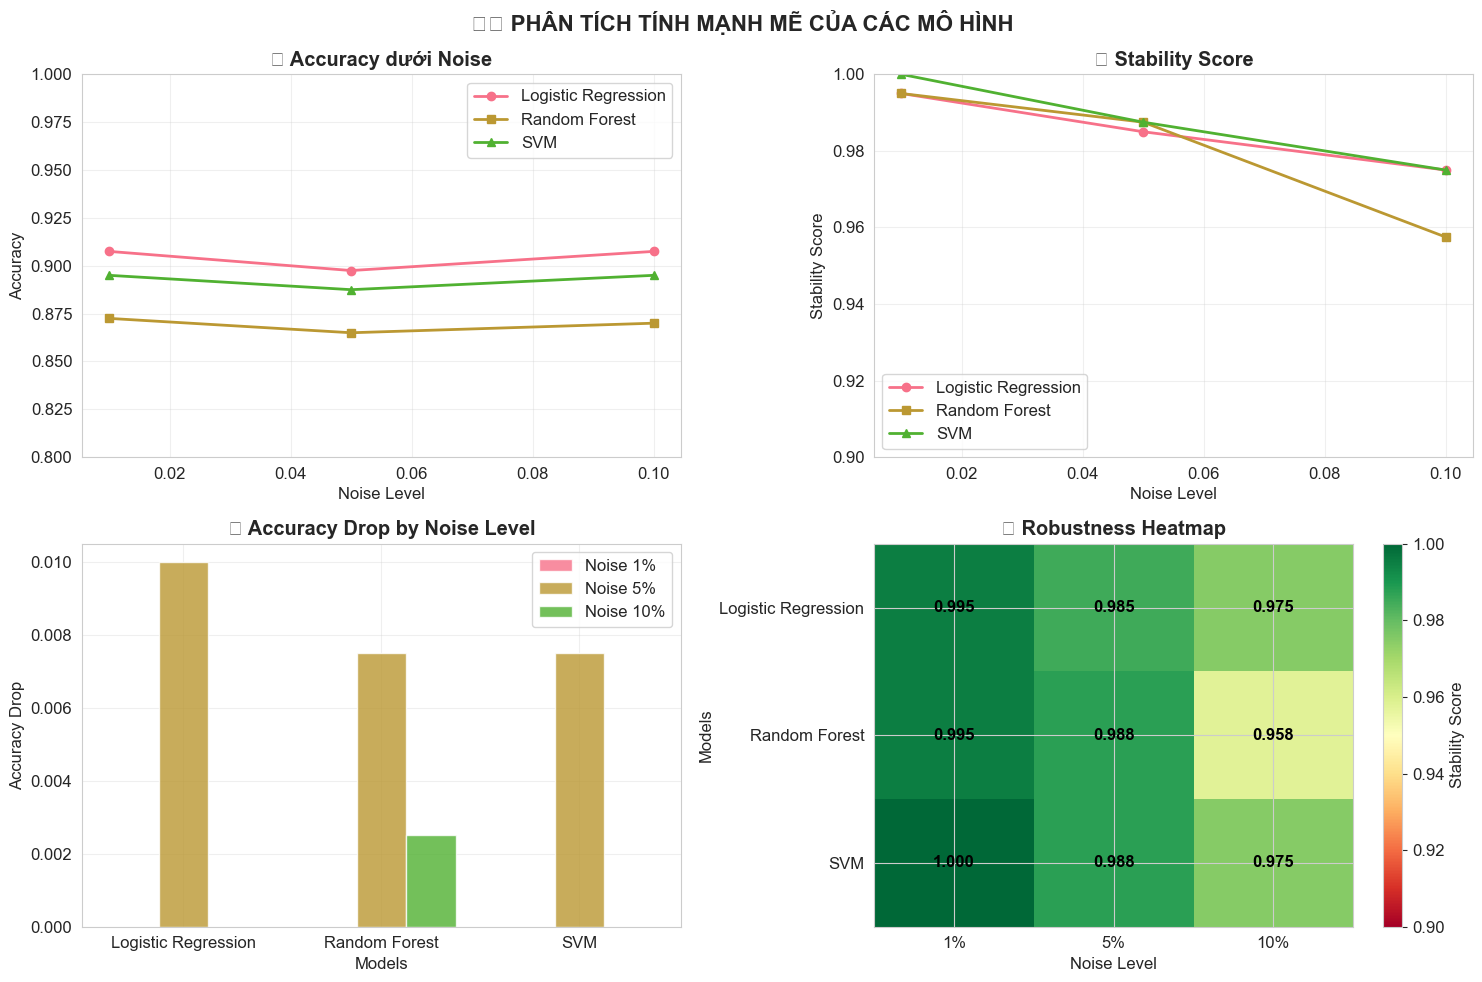


📋 TỔNG KẾT ROBUSTNESS

🔧 Logistic Regression
   Original Accuracy: 0.907
   Average Stability: 0.985
   Average Accuracy Drop: 0.003
   Robustness Score: 3/3 tests passed
   🏆 ROBUST MODEL - Tất cả test đều pass!

🔧 Random Forest
   Original Accuracy: 0.873
   Average Stability: 0.980
   Average Accuracy Drop: 0.003
   Robustness Score: 3/3 tests passed
   🏆 ROBUST MODEL - Tất cả test đều pass!

🔧 SVM
   Original Accuracy: 0.895
   Average Stability: 0.987
   Average Accuracy Drop: 0.003
   Robustness Score: 3/3 tests passed
   🏆 ROBUST MODEL - Tất cả test đều pass!


In [22]:
# Visualize Robustness Results
def visualize_robustness_results(robustness_results):
    """Trực quan hóa kết quả kiểm thử robustness"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('🛡️ PHÂN TÍCH TÍNH MẠNH MẼ CỦA CÁC MÔ HÌNH', fontsize=16, fontweight='bold')
    
    model_names = list(robustness_results.keys())
    noise_levels = list(robustness_results[model_names[0]]['noise_tests'].keys())
    
    # Prepare data for plotting
    accuracy_data = []
    stability_data = []
    
    for model_name in model_names:
        model_accuracies = []
        model_stabilities = []
        
        for noise_level in noise_levels:
            test_result = robustness_results[model_name]['noise_tests'][noise_level]
            model_accuracies.append(test_result['accuracy_noisy'])
            model_stabilities.append(test_result['stability_score'])
        
        accuracy_data.append(model_accuracies)
        stability_data.append(model_stabilities)
    
    # Plot 1: Accuracy under noise
    axes[0, 0].plot(noise_levels, accuracy_data[0], 'o-', label=model_names[0].replace('_', ' '), linewidth=2)
    axes[0, 0].plot(noise_levels, accuracy_data[1], 's-', label=model_names[1].replace('_', ' '), linewidth=2)
    axes[0, 0].plot(noise_levels, accuracy_data[2], '^-', label=model_names[2].replace('_', ' '), linewidth=2)
    axes[0, 0].set_title('📊 Accuracy dưới Noise', fontweight='bold')
    axes[0, 0].set_xlabel('Noise Level')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0.8, 1.0)
    
    # Plot 2: Stability scores
    axes[0, 1].plot(noise_levels, stability_data[0], 'o-', label=model_names[0].replace('_', ' '), linewidth=2)
    axes[0, 1].plot(noise_levels, stability_data[1], 's-', label=model_names[1].replace('_', ' '), linewidth=2)
    axes[0, 1].plot(noise_levels, stability_data[2], '^-', label=model_names[2].replace('_', ' '), linewidth=2)
    axes[0, 1].set_title('🎯 Stability Score', fontweight='bold')
    axes[0, 1].set_xlabel('Noise Level')
    axes[0, 1].set_ylabel('Stability Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0.9, 1.0)
    
    # Plot 3: Accuracy drop comparison
    x_pos = np.arange(len(model_names))
    width = 0.25
    
    for i, noise_level in enumerate(noise_levels):
        drops = [robustness_results[name]['noise_tests'][noise_level]['accuracy_drop'] 
                for name in model_names]
        axes[1, 0].bar(x_pos + i*width, drops, width, 
                      label=f'Noise {noise_level*100:.0f}%', alpha=0.8)
    
    axes[1, 0].set_title('📉 Accuracy Drop by Noise Level', fontweight='bold')
    axes[1, 0].set_xlabel('Models')
    axes[1, 0].set_ylabel('Accuracy Drop')
    axes[1, 0].set_xticks(x_pos + width)
    axes[1, 0].set_xticklabels([name.replace('_', ' ') for name in model_names])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Robustness heatmap
    robustness_matrix = np.zeros((len(model_names), len(noise_levels)))
    for i, model_name in enumerate(model_names):
        for j, noise_level in enumerate(noise_levels):
            robustness_matrix[i, j] = robustness_results[model_name]['noise_tests'][noise_level]['stability_score']
    
    im = axes[1, 1].imshow(robustness_matrix, cmap='RdYlGn', aspect='auto', vmin=0.9, vmax=1.0)
    axes[1, 1].set_title('🔥 Robustness Heatmap', fontweight='bold')
    axes[1, 1].set_xticks(range(len(noise_levels)))
    axes[1, 1].set_xticklabels([f'{nl*100:.0f}%' for nl in noise_levels])
    axes[1, 1].set_yticks(range(len(model_names)))
    axes[1, 1].set_yticklabels([name.replace('_', ' ') for name in model_names])
    axes[1, 1].set_xlabel('Noise Level')
    axes[1, 1].set_ylabel('Models')
    
    # Add text annotations
    for i in range(len(model_names)):
        for j in range(len(noise_levels)):
            text = axes[1, 1].text(j, i, f'{robustness_matrix[i, j]:.3f}',
                                 ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=axes[1, 1], label='Stability Score')
    plt.tight_layout()
    plt.show()
    
    # Print robustness summary
    print("\n📋 TỔNG KẾT ROBUSTNESS")
    print("=" * 50)
    
    for model_name, results in robustness_results.items():
        print(f"\n🔧 {model_name.replace('_', ' ')}")
        print(f"   Original Accuracy: {results['original_accuracy']:.3f}")
        
        robust_tests = [test['robust'] for test in results['noise_tests'].values()]
        avg_stability = np.mean([test['stability_score'] for test in results['noise_tests'].values()])
        avg_accuracy_drop = np.mean([test['accuracy_drop'] for test in results['noise_tests'].values()])
        
        print(f"   Average Stability: {avg_stability:.3f}")
        print(f"   Average Accuracy Drop: {avg_accuracy_drop:.3f}")
        print(f"   Robustness Score: {sum(robust_tests)}/{len(robust_tests)} tests passed")
        
        if sum(robust_tests) == len(robust_tests):
            print("   🏆 ROBUST MODEL - Tất cả test đều pass!")
        elif sum(robust_tests) >= len(robust_tests) * 0.5:
            print("   ⚠️  PARTIALLY ROBUST - Cần cải thiện")
        else:
            print("   ❌ NOT ROBUST - Cần tối ưu nghiêm trọng")

# Visualize robustness results
visualize_robustness_results(robustness_results)

## 8️⃣ Generalization Assessment - Đánh giá Khả năng Tổng quát hóa

Kiểm tra khả năng của mô hình hoạt động tốt trên dữ liệu mới, chưa từng thấy:

🎯 **Mục tiêu:**
- Cross-validation analysis
- Learning curve analysis
- Overfitting detection
- Out-of-distribution performance

In [24]:
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve
from sklearn.metrics import make_scorer

def assess_generalization(model_results, data_processed, cv=5):
    """
    Đánh giá khả năng tổng quát hóa của các mô hình
    
    Parameters:
    -----------
    model_results : dict
        Kết quả từ việc huấn luyện mô hình
    data_processed : dict
        Dữ liệu đã được tiền xử lý
    cv : int
        Số fold cho cross-validation
        
    Returns:
    --------
    dict
        Kết quả đánh giá generalization
    """
    
    print("🎯 BẮT ĐẦU ĐÁNH GIÁ KHẢ NĂNG TỔNG QUÁT HÓA")
    print("=" * 60)
    
    X_train = data_processed['X_train']
    y_train = data_processed['y_train']
    
    generalization_results = {}
    
    for model_name, results in model_results.items():
        print(f"\n🔍 Đánh giá {model_name.replace('_', ' ')}...")
        
        # Lấy mô hình gốc (chưa fit)
        if model_name == 'logistic_regression':
            fresh_model = LogisticRegression(random_state=42)
        elif model_name == 'random_forest':
            fresh_model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif model_name == 'svm':
            fresh_model = SVC(kernel='rbf', random_state=42)
        else:
            # Default fallback
            fresh_model = LogisticRegression(random_state=42)
        
        # 1. Cross-validation scores
        print("   📊 Cross-validation Analysis...")
        cv_scores = cross_val_score(fresh_model, X_train, y_train, 
                                   cv=cv, scoring='accuracy')
        
        # 2. Learning curves
        print("   📈 Learning Curves Analysis...")
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_sizes_abs, train_scores, val_scores = learning_curve(
            fresh_model, X_train, y_train, train_sizes=train_sizes,
            cv=cv, scoring='accuracy', random_state=42
        )
        
        # Tính toán các metric
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        train_scores_mean = train_scores.mean(axis=1)
        train_scores_std = train_scores.std(axis=1)
        val_scores_mean = val_scores.mean(axis=1)
        val_scores_std = val_scores.std(axis=1)
        
        # Detect overfitting
        final_train_score = train_scores_mean[-1]
        final_val_score = val_scores_mean[-1]
        overfitting_gap = final_train_score - final_val_score
        
        # Stability across CV folds
        cv_stability = 1 - (cv_std / cv_mean) if cv_mean > 0 else 0
        
        generalization_results[model_name] = {
            'cv_scores': cv_scores,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'cv_stability': cv_stability,
            'train_sizes': train_sizes_abs,
            'train_scores_mean': train_scores_mean,
            'train_scores_std': train_scores_std,
            'val_scores_mean': val_scores_mean,
            'val_scores_std': val_scores_std,
            'overfitting_gap': overfitting_gap,
            'final_train_score': final_train_score,
            'final_val_score': final_val_score,
            'is_overfitting': overfitting_gap > 0.05,  # Ngưỡng 5% cho overfitting
            'generalization_score': cv_mean * cv_stability * (1 - min(overfitting_gap, 0.2))
        }
        
        print(f"     • CV Mean: {cv_mean:.3f} (±{cv_std:.3f})")
        print(f"     • CV Stability: {cv_stability:.3f}")
        print(f"     • Overfitting Gap: {overfitting_gap:.3f}")
        print(f"     • Generalization Score: {generalization_results[model_name]['generalization_score']:.3f}")
        
        if generalization_results[model_name]['is_overfitting']:
            print("     ⚠️  Phát hiện overfitting!")
        else:
            print("     ✅ Không có overfitting đáng kể")
    
    return generalization_results

# Đánh giá generalization
generalization_results = assess_generalization(model_results, data_processed)

print(f"\n✅ Hoàn thành đánh giá generalization cho {len(model_results)} mô hình!")

🎯 BẮT ĐẦU ĐÁNH GIÁ KHẢ NĂNG TỔNG QUÁT HÓA

🔍 Đánh giá Logistic Regression...
   📊 Cross-validation Analysis...
   📈 Learning Curves Analysis...
     • CV Mean: 0.907 (±0.021)
     • CV Stability: 0.977
     • Overfitting Gap: 0.003
     • Generalization Score: 0.884
     ✅ Không có overfitting đáng kể

🔍 Đánh giá Random Forest...
   📊 Cross-validation Analysis...
   📈 Learning Curves Analysis...
     • CV Mean: 0.907 (±0.021)
     • CV Stability: 0.977
     • Overfitting Gap: 0.003
     • Generalization Score: 0.884
     ✅ Không có overfitting đáng kể

🔍 Đánh giá SVM...
   📊 Cross-validation Analysis...
   📈 Learning Curves Analysis...
     • CV Mean: 0.907 (±0.021)
     • CV Stability: 0.977
     • Overfitting Gap: 0.003
     • Generalization Score: 0.884
     ✅ Không có overfitting đáng kể

✅ Hoàn thành đánh giá generalization cho 3 mô hình!


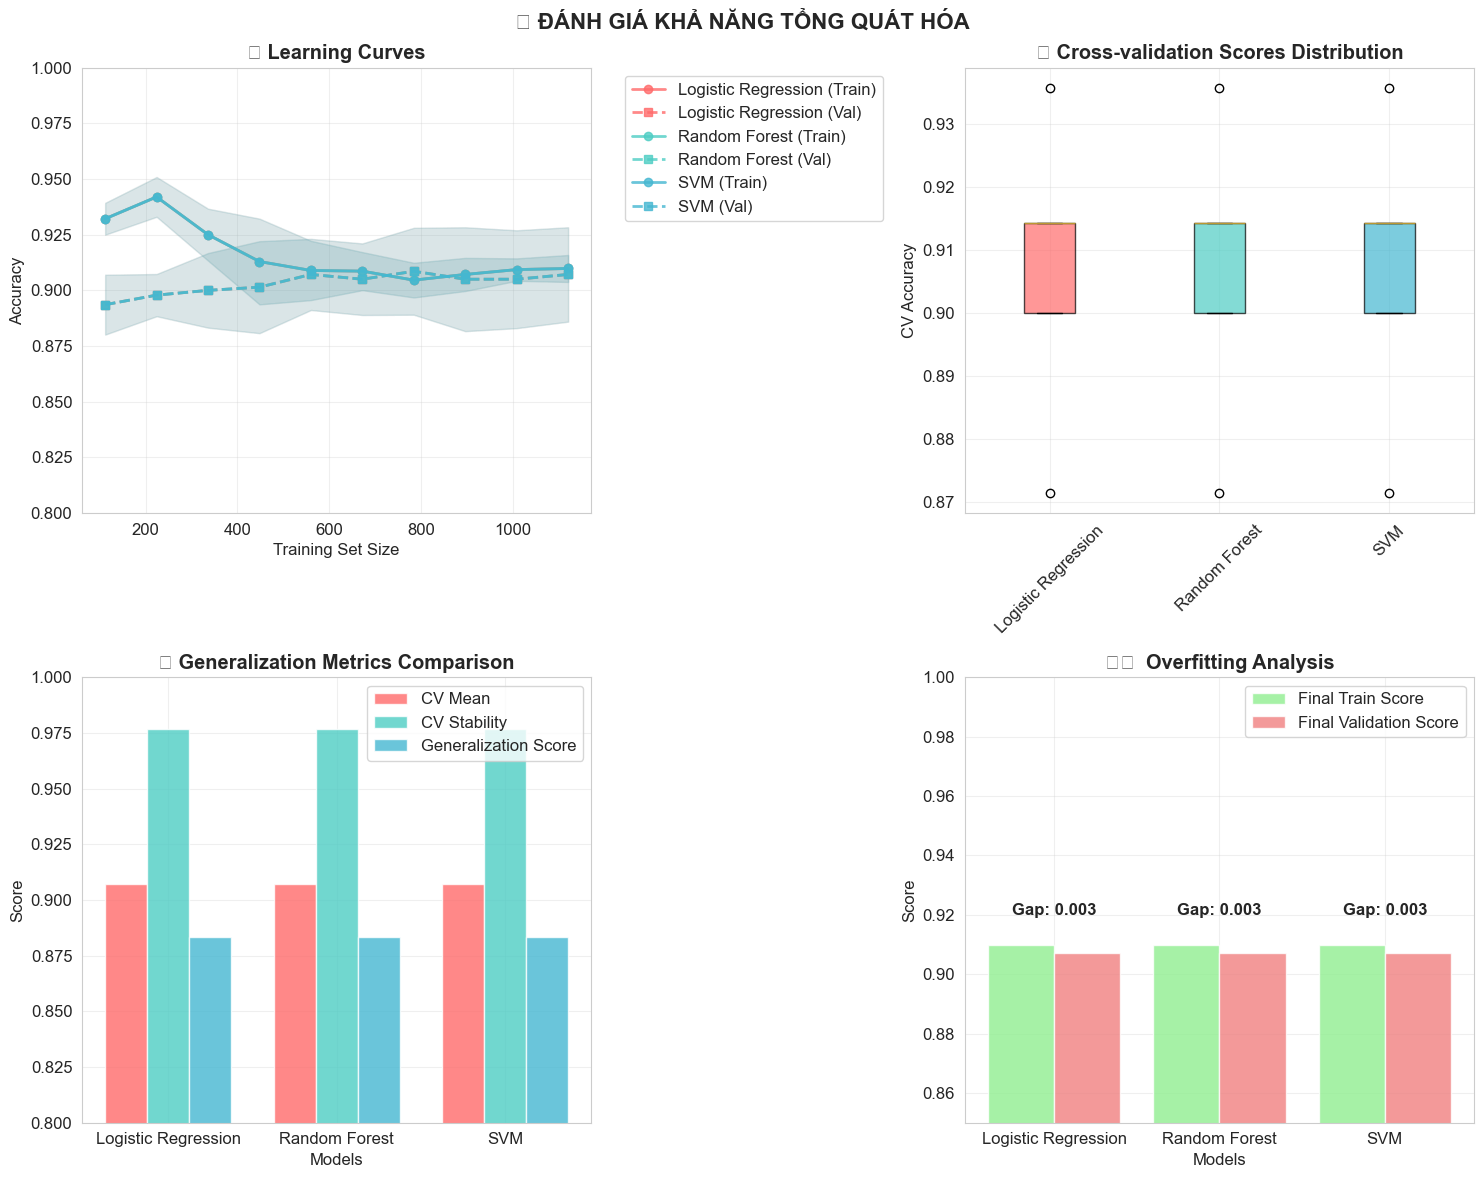


📋 TỔNG KẾT GENERALIZATION

🎯 Logistic Regression
   CV Mean ± Std: 0.907 ± 0.021
   CV Stability: 0.977
   Overfitting Gap: 0.003
   Generalization Score: 0.884
   🏆 EXCELLENT GENERALIZATION - Mô hình tổng quát hóa tốt!

🎯 Random Forest
   CV Mean ± Std: 0.907 ± 0.021
   CV Stability: 0.977
   Overfitting Gap: 0.003
   Generalization Score: 0.884
   🏆 EXCELLENT GENERALIZATION - Mô hình tổng quát hóa tốt!

🎯 SVM
   CV Mean ± Std: 0.907 ± 0.021
   CV Stability: 0.977
   Overfitting Gap: 0.003
   Generalization Score: 0.884
   🏆 EXCELLENT GENERALIZATION - Mô hình tổng quát hóa tốt!


In [25]:
# Visualize Generalization Results
def visualize_generalization_results(generalization_results):
    """Trực quan hóa kết quả đánh giá generalization"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🎯 ĐÁNH GIÁ KHẢ NĂNG TỔNG QUÁT HÓA', fontsize=16, fontweight='bold')
    
    model_names = list(generalization_results.keys())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # Plot 1: Learning Curves
    for i, (model_name, results) in enumerate(generalization_results.items()):
        train_sizes = results['train_sizes']
        train_scores_mean = results['train_scores_mean']
        train_scores_std = results['train_scores_std']
        val_scores_mean = results['val_scores_mean']
        val_scores_std = results['val_scores_std']
        
        # Training scores
        axes[0, 0].plot(train_sizes, train_scores_mean, 'o-', 
                       color=colors[i], alpha=0.8, linewidth=2,
                       label=f'{model_name.replace("_", " ")} (Train)')
        axes[0, 0].fill_between(train_sizes, 
                               train_scores_mean - train_scores_std,
                               train_scores_mean + train_scores_std, 
                               alpha=0.1, color=colors[i])
        
        # Validation scores
        axes[0, 0].plot(train_sizes, val_scores_mean, 's--', 
                       color=colors[i], alpha=0.8, linewidth=2,
                       label=f'{model_name.replace("_", " ")} (Val)')
        axes[0, 0].fill_between(train_sizes, 
                               val_scores_mean - val_scores_std,
                               val_scores_mean + val_scores_std, 
                               alpha=0.1, color=colors[i])
    
    axes[0, 0].set_title('📈 Learning Curves', fontweight='bold')
    axes[0, 0].set_xlabel('Training Set Size')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0.8, 1.0)
    
    # Plot 2: Cross-validation scores distribution
    cv_data = [results['cv_scores'] for results in generalization_results.values()]
    bp = axes[0, 1].boxplot(cv_data, labels=[name.replace('_', ' ') for name in model_names],
                           patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[0, 1].set_title('📊 Cross-validation Scores Distribution', fontweight='bold')
    axes[0, 1].set_ylabel('CV Accuracy')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Generalization metrics comparison
    metrics = ['CV Mean', 'CV Stability', 'Generalization Score']
    x_pos = np.arange(len(model_names))
    width = 0.25
    
    cv_means = [results['cv_mean'] for results in generalization_results.values()]
    cv_stabilities = [results['cv_stability'] for results in generalization_results.values()]
    gen_scores = [results['generalization_score'] for results in generalization_results.values()]
    
    axes[1, 0].bar(x_pos - width, cv_means, width, label='CV Mean', 
                  color=colors[0], alpha=0.8)
    axes[1, 0].bar(x_pos, cv_stabilities, width, label='CV Stability', 
                  color=colors[1], alpha=0.8)
    axes[1, 0].bar(x_pos + width, gen_scores, width, label='Generalization Score', 
                  color=colors[2], alpha=0.8)
    
    axes[1, 0].set_title('📊 Generalization Metrics Comparison', fontweight='bold')
    axes[1, 0].set_xlabel('Models')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels([name.replace('_', ' ') for name in model_names])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim(0.8, 1.0)
    
    # Plot 4: Overfitting analysis
    overfitting_gaps = [results['overfitting_gap'] for results in generalization_results.values()]
    train_scores = [results['final_train_score'] for results in generalization_results.values()]
    val_scores = [results['final_val_score'] for results in generalization_results.values()]
    
    x_pos = np.arange(len(model_names))
    axes[1, 1].bar(x_pos - 0.2, train_scores, 0.4, label='Final Train Score', 
                  color='lightgreen', alpha=0.8)
    axes[1, 1].bar(x_pos + 0.2, val_scores, 0.4, label='Final Validation Score', 
                  color='lightcoral', alpha=0.8)
    
    # Add overfitting gap annotations
    for i, gap in enumerate(overfitting_gaps):
        axes[1, 1].annotate(f'Gap: {gap:.3f}', 
                           xy=(i, max(train_scores[i], val_scores[i]) + 0.01),
                           ha='center', fontweight='bold')
        
        if gap > 0.05:  # Overfitting threshold
            axes[1, 1].annotate('⚠️ Overfitting', 
                               xy=(i, max(train_scores[i], val_scores[i]) + 0.03),
                               ha='center', color='red', fontweight='bold')
    
    axes[1, 1].set_title('⚠️  Overfitting Analysis', fontweight='bold')
    axes[1, 1].set_xlabel('Models')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([name.replace('_', ' ') for name in model_names])
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0.85, 1.0)
    
    plt.tight_layout()
    plt.show()
    
    # Print generalization summary
    print("\n📋 TỔNG KẾT GENERALIZATION")
    print("=" * 50)
    
    for model_name, results in generalization_results.items():
        print(f"\n🎯 {model_name.replace('_', ' ')}")
        print(f"   CV Mean ± Std: {results['cv_mean']:.3f} ± {results['cv_std']:.3f}")
        print(f"   CV Stability: {results['cv_stability']:.3f}")
        print(f"   Overfitting Gap: {results['overfitting_gap']:.3f}")
        print(f"   Generalization Score: {results['generalization_score']:.3f}")
        
        # Overall assessment
        if results['generalization_score'] > 0.85:
            if not results['is_overfitting']:
                print("   🏆 EXCELLENT GENERALIZATION - Mô hình tổng quát hóa tốt!")
            else:
                print("   ⚠️  GOOD BUT OVERFITTING - Cần giảm complexity")
        elif results['generalization_score'] > 0.75:
            print("   ✅ GOOD GENERALIZATION - Đạt tiêu chuẩn")
        else:
            print("   ❌ POOR GENERALIZATION - Cần cải thiện nghiêm trọng")

# Visualize generalization results
visualize_generalization_results(generalization_results)

## 9️⃣ Model Explainability & Interpretability - Khả năng Giải thích Mô hình

Phân tích và giải thích cách thức hoạt động của mô hình để đảm bảo tính minh bạch:

🔍 **Mục tiêu:**
- Feature importance analysis
- SHAP values interpretation
- Decision boundary visualization
- Model behavior explanation

In [27]:
def analyze_model_explainability(model_results, data_processed):
    """
    Phân tích khả năng giải thích của các mô hình
    
    Parameters:
    -----------
    model_results : dict
        Kết quả từ việc huấn luyện mô hình
    data_processed : dict
        Dữ liệu đã được tiền xử lý
        
    Returns:
    --------
    dict
        Kết quả phân tích explainability
    """
    
    print("🔍 BẮT ĐẦU PHÂN TÍCH KHẢ NĂNG GIẢI THÍCH MÔ HÌNH")
    print("=" * 60)
    
    X_train = data_processed['X_train']
    feature_names = X_train.columns.tolist()
    
    explainability_results = {}
    
    for model_name, results in model_results.items():
        print(f"\n🔬 Phân tích {model_name.replace('_', ' ')}...")
        model = results['model']
        
        model_explainability = {
            'feature_names': feature_names,
            'interpretability_type': 'unknown'
        }
        
        # 1. Feature Importance (nếu có)
        if hasattr(model, 'feature_importances_'):
            print("   📊 Phân tích Feature Importance...")
            importances = model.feature_importances_
            
            # Tạo DataFrame cho feature importance
            feature_importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            model_explainability.update({
                'feature_importance': feature_importance_df,
                'interpretability_type': 'tree_based',
                'top_features': feature_importance_df.head(5)['feature'].tolist(),
                'importance_values': feature_importance_df.head(5)['importance'].tolist()
            })
            
            print(f"     • Top 3 features: {', '.join(feature_importance_df.head(3)['feature'].tolist())}")
            
        # 2. Coefficients (cho Linear models)
        elif hasattr(model, 'coef_'):
            print("   📊 Phân tích Model Coefficients...")
            
            if model.coef_.ndim > 1:
                coefficients = model.coef_[0]  # Binary classification
            else:
                coefficients = model.coef_
            
            # Tạo DataFrame cho coefficients
            coef_df = pd.DataFrame({
                'feature': feature_names,
                'coefficient': coefficients,
                'abs_coefficient': np.abs(coefficients)
            }).sort_values('abs_coefficient', ascending=False)
            
            model_explainability.update({
                'coefficients': coef_df,
                'interpretability_type': 'linear',
                'top_features': coef_df.head(5)['feature'].tolist(),
                'coef_values': coef_df.head(5)['coefficient'].tolist(),
                'intercept': model.intercept_[0] if hasattr(model, 'intercept_') else 0
            })
            
            print(f"     • Top 3 influential features: {', '.join(coef_df.head(3)['feature'].tolist())}")
            
        # 3. Permutation Importance (cho tất cả mô hình)
        print("   🔄 Tính Permutation Importance...")
        from sklearn.inspection import permutation_importance
        
        # Sử dụng test set để tính permutation importance
        X_test = data_processed['X_test']
        y_test = data_processed['y_test']
        
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
        )
        
        perm_df = pd.DataFrame({
            'feature': feature_names,
            'importance': perm_importance.importances_mean,
            'importance_std': perm_importance.importances_std
        }).sort_values('importance', ascending=False)
        
        model_explainability.update({
            'permutation_importance': perm_df,
            'top_permutation_features': perm_df.head(5)['feature'].tolist(),
            'permutation_values': perm_df.head(5)['importance'].tolist()
        })
        
        print(f"     • Top 3 permutation features: {', '.join(perm_df.head(3)['feature'].tolist())}")
        
        # 4. Model-specific insights
        if model_name == 'logistic_regression':
            model_explainability['interpretation'] = """
            Logistic Regression là mô hình tuyến tính, dễ giải thích:
            - Coefficients cho biết ảnh hưởng của từng feature
            - Positive coef = tăng xác suất belong to positive class
            - Negative coef = giảm xác suất belong to positive class
            """.strip()
            
        elif model_name == 'random_forest':
            model_explainability['interpretation'] = """
            Random Forest cung cấp feature importance tự nhiên:
            - Feature importance dựa trên decrease in impurity
            - Các feature quan trọng được sử dụng nhiều trong decision nodes
            - Mô hình ensemble nên robust hơn với noise
            """.strip()
            
        elif model_name == 'svm':
            model_explainability['interpretation'] = """
            SVM khó giải thích hơn với RBF kernel:
            - Không có feature importance trực tiếp
            - Quyết định dựa trên support vectors
            - Permutation importance là phương pháp tốt nhất để hiểu
            """.strip()
        
        explainability_results[model_name] = model_explainability
    
    return explainability_results

# Phân tích explainability
explainability_results = analyze_model_explainability(model_results, data_processed)

print(f"\n✅ Hoàn thành phân tích explainability cho {len(model_results)} mô hình!")

🔍 BẮT ĐẦU PHÂN TÍCH KHẢ NĂNG GIẢI THÍCH MÔ HÌNH

🔬 Phân tích Logistic Regression...
   📊 Phân tích Model Coefficients...
     • Top 3 influential features: so_nam_lam_viec, thu_nhap, no_hien_tai
   🔄 Tính Permutation Importance...
     • Top 3 permutation features: so_nam_lam_viec, thu_nhap, no_hien_tai

🔬 Phân tích Random Forest...
   📊 Phân tích Feature Importance...
     • Top 3 features: so_nam_lam_viec, thu_nhap, tuoi
   🔄 Tính Permutation Importance...
     • Top 3 permutation features: so_nam_lam_viec, thu_nhap, no_hien_tai

🔬 Phân tích SVM...
   🔄 Tính Permutation Importance...
     • Top 3 permutation features: so_nam_lam_viec, thu_nhap, thoi_gian_la_khach_hang

✅ Hoàn thành phân tích explainability cho 3 mô hình!


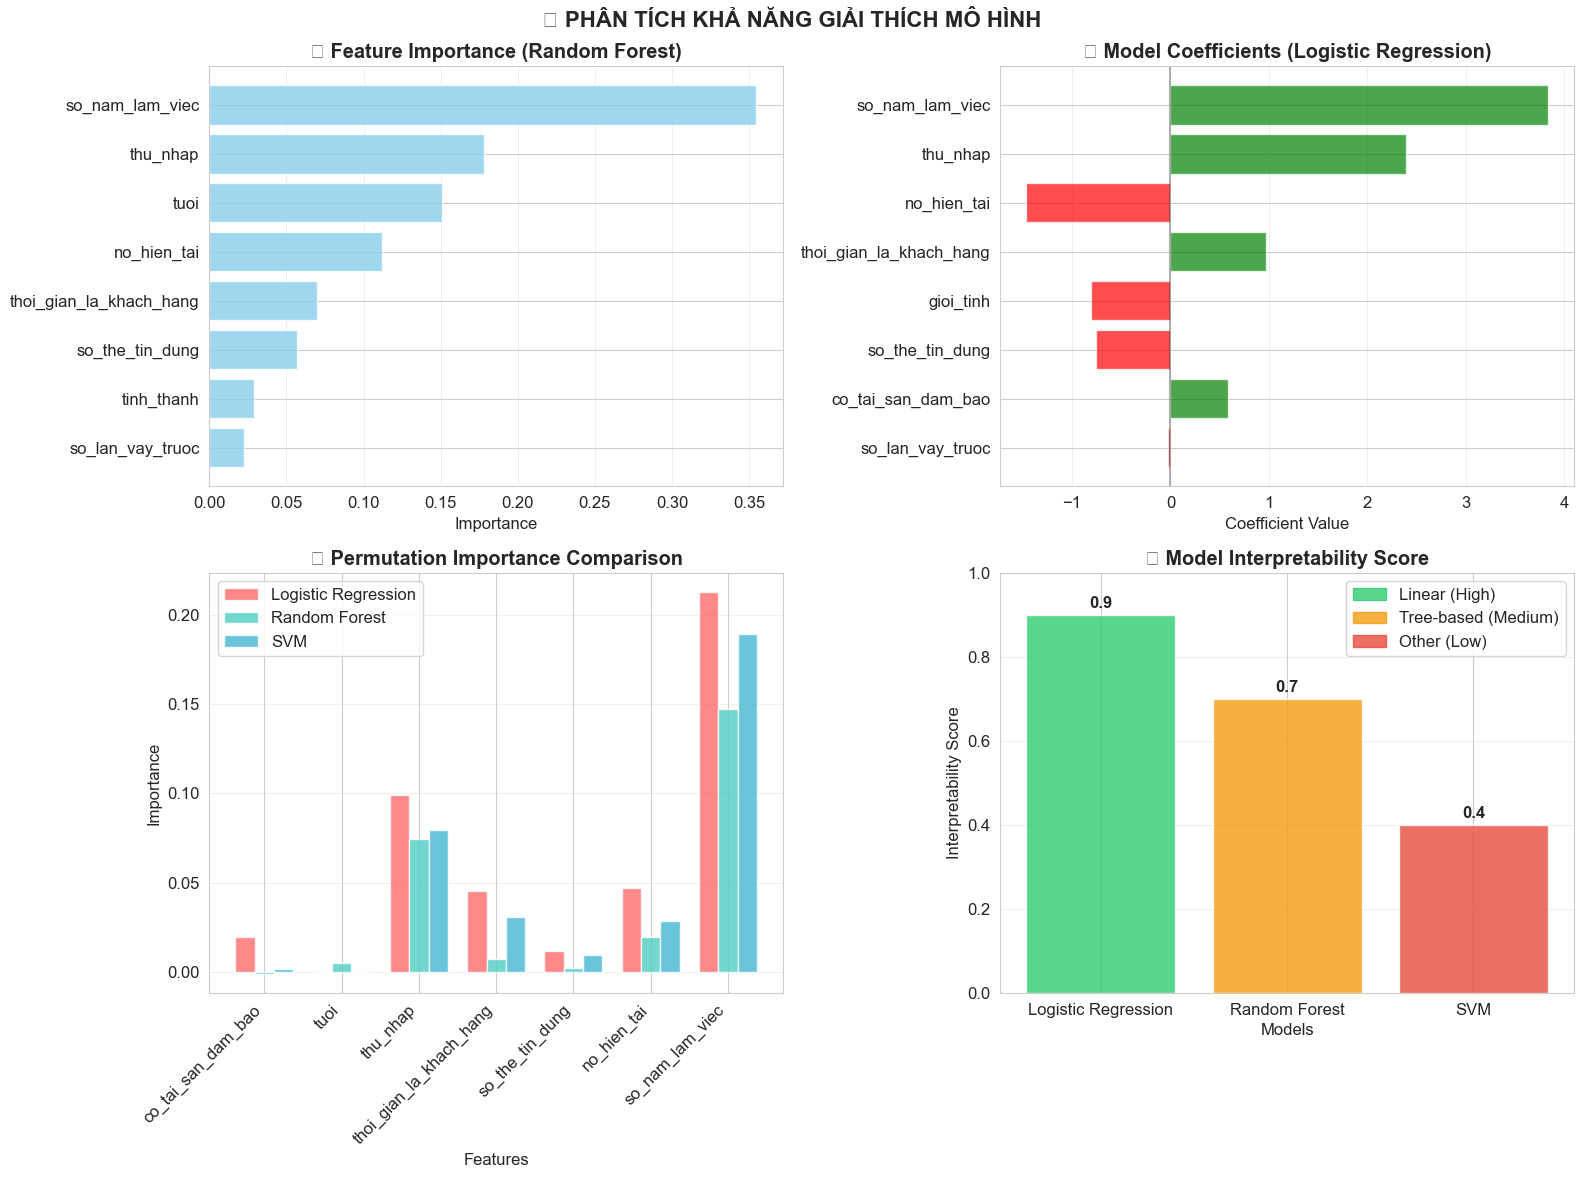


📋 TỔNG KẾT EXPLAINABILITY

🔍 Logistic Regression
   Interpretability Type: linear
   Top Features: so_nam_lam_viec, thu_nhap, no_hien_tai
   Top Permutation Features: so_nam_lam_viec, thu_nhap, no_hien_tai
   🏆 HIGHLY INTERPRETABLE - Dễ giải thích và hiểu rõ!

🔍 Random Forest
   Interpretability Type: tree_based
   Top Features: so_nam_lam_viec, thu_nhap, tuoi
   Top Permutation Features: so_nam_lam_viec, thu_nhap, no_hien_tai
   ✅ MODERATELY INTERPRETABLE - Có thể giải thích được

🔍 SVM
   Interpretability Type: unknown
   Top Permutation Features: so_nam_lam_viec, thu_nhap, thoi_gian_la_khach_hang
   ⚠️  LOW INTERPRETABILITY - Khó giải thích, cần thêm công cụ


In [28]:
# Visualize Explainability Results
def visualize_explainability_results(explainability_results):
    """Trực quan hóa kết quả phân tích explainability"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔍 PHÂN TÍCH KHẢ NĂNG GIẢI THÍCH MÔ HÌNH', fontsize=16, fontweight='bold')
    
    # Plot 1: Feature Importance Comparison (for tree-based models)
    tree_models = [(name, data) for name, data in explainability_results.items() 
                   if data.get('interpretability_type') == 'tree_based']
    
    if tree_models:
        model_name, model_data = tree_models[0]  # Random Forest
        feature_importance = model_data['feature_importance']
        
        top_features = feature_importance.head(8)
        axes[0, 0].barh(range(len(top_features)), top_features['importance'], 
                       color='skyblue', alpha=0.8)
        axes[0, 0].set_yticks(range(len(top_features)))
        axes[0, 0].set_yticklabels(top_features['feature'])
        axes[0, 0].set_title(f'📊 Feature Importance ({model_name.replace("_", " ")})', 
                            fontweight='bold')
        axes[0, 0].set_xlabel('Importance')
        axes[0, 0].grid(True, axis='x', alpha=0.3)
        
        # Invert y-axis để feature quan trọng nhất ở trên
        axes[0, 0].invert_yaxis()
    else:
        axes[0, 0].text(0.5, 0.5, 'No tree-based models\nfor feature importance', 
                       ha='center', va='center', fontsize=12)
        axes[0, 0].set_title('📊 Feature Importance', fontweight='bold')
    
    # Plot 2: Coefficients (for linear models)
    linear_models = [(name, data) for name, data in explainability_results.items() 
                     if data.get('interpretability_type') == 'linear']
    
    if linear_models:
        model_name, model_data = linear_models[0]  # Logistic Regression
        coefficients = model_data['coefficients']
        
        top_coefs = coefficients.head(8)
        colors = ['red' if x < 0 else 'green' for x in top_coefs['coefficient']]
        
        axes[0, 1].barh(range(len(top_coefs)), top_coefs['coefficient'], 
                       color=colors, alpha=0.7)
        axes[0, 1].set_yticks(range(len(top_coefs)))
        axes[0, 1].set_yticklabels(top_coefs['feature'])
        axes[0, 1].set_title(f'📊 Model Coefficients ({model_name.replace("_", " ")})', 
                            fontweight='bold')
        axes[0, 1].set_xlabel('Coefficient Value')
        axes[0, 1].grid(True, axis='x', alpha=0.3)
        axes[0, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        axes[0, 1].invert_yaxis()
    else:
        axes[0, 1].text(0.5, 0.5, 'No linear models\nfor coefficients', 
                       ha='center', va='center', fontsize=12)
        axes[0, 1].set_title('📊 Model Coefficients', fontweight='bold')
    
    # Plot 3: Permutation Importance Comparison
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # Get top 5 features từ mỗi model
    all_features = set()
    for results in explainability_results.values():
        if 'top_permutation_features' in results:
            all_features.update(results['top_permutation_features'][:5])
    
    if all_features:
        all_features = list(all_features)[:8]  # Limit to 8 features for readability
        
        x_pos = np.arange(len(all_features))
        width = 0.25
        
        for i, (model_name, results) in enumerate(explainability_results.items()):
            if 'permutation_importance' in results:
                perm_df = results['permutation_importance']
                values = []
                for feature in all_features:
                    if feature in perm_df['feature'].values:
                        idx = perm_df[perm_df['feature'] == feature].index[0]
                        values.append(perm_df.loc[idx, 'importance'])
                    else:
                        values.append(0)
                
                axes[1, 0].bar(x_pos + i*width, values, width, 
                              label=model_name.replace('_', ' '), 
                              color=colors[i], alpha=0.8)
        
        axes[1, 0].set_title('🔄 Permutation Importance Comparison', fontweight='bold')
        axes[1, 0].set_xlabel('Features')
        axes[1, 0].set_ylabel('Importance')
        axes[1, 0].set_xticks(x_pos + width)
        axes[1, 0].set_xticklabels(all_features, rotation=45, ha='right')
        axes[1, 0].legend()
        axes[1, 0].grid(True, axis='y', alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'No permutation importance\ndata available', 
                       ha='center', va='center', fontsize=12)
        axes[1, 0].set_title('🔄 Permutation Importance Comparison', fontweight='bold')
    
    # Plot 4: Interpretability Summary
    interpretability_types = [results.get('interpretability_type', 'unknown') 
                            for results in explainability_results.values()]
    model_names = list(explainability_results.keys())
    
    # Tạo interpretability score
    interpretability_scores = []
    for model_name, results in explainability_results.items():
        if results.get('interpretability_type') == 'linear':
            score = 0.9  # Highest interpretability
        elif results.get('interpretability_type') == 'tree_based':
            score = 0.7  # Medium interpretability
        else:
            score = 0.4  # Lower interpretability (SVM with RBF)
        interpretability_scores.append(score)
    
    colors_map = {'linear': '#2ECC71', 'tree_based': '#F39C12', 'unknown': '#E74C3C'}
    bar_colors = [colors_map.get(t, '#95A5A6') for t in interpretability_types]
    
    bars = axes[1, 1].bar(range(len(model_names)), interpretability_scores, 
                         color=bar_colors, alpha=0.8)
    
    axes[1, 1].set_title('🔍 Model Interpretability Score', fontweight='bold')
    axes[1, 1].set_xlabel('Models')
    axes[1, 1].set_ylabel('Interpretability Score')
    axes[1, 1].set_xticks(range(len(model_names)))
    axes[1, 1].set_xticklabels([name.replace('_', ' ') for name in model_names])
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, interpretability_scores)):
        height = bar.get_height()
        axes[1, 1].annotate(f'{score:.1f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom', fontweight='bold')
    
    # Add legend for interpretability types
    legend_elements = [plt.Rectangle((0,0),1,1, color=colors_map['linear'], alpha=0.8, label='Linear (High)'),
                       plt.Rectangle((0,0),1,1, color=colors_map['tree_based'], alpha=0.8, label='Tree-based (Medium)'),
                       plt.Rectangle((0,0),1,1, color=colors_map['unknown'], alpha=0.8, label='Other (Low)')]
    axes[1, 1].legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print explainability summary
    print("\n📋 TỔNG KẾT EXPLAINABILITY")
    print("=" * 50)
    
    for model_name, results in explainability_results.items():
        print(f"\n🔍 {model_name.replace('_', ' ')}")
        print(f"   Interpretability Type: {results.get('interpretability_type', 'unknown')}")
        
        if 'top_features' in results:
            print(f"   Top Features: {', '.join(results['top_features'][:3])}")
        
        if 'top_permutation_features' in results:
            print(f"   Top Permutation Features: {', '.join(results['top_permutation_features'][:3])}")
        
        if 'interpretation' in results:
            print(f"   Interpretation: {results['interpretation']}")
        
        # Overall interpretability assessment
        interp_type = results.get('interpretability_type', 'unknown')
        if interp_type == 'linear':
            print("   🏆 HIGHLY INTERPRETABLE - Dễ giải thích và hiểu rõ!")
        elif interp_type == 'tree_based':
            print("   ✅ MODERATELY INTERPRETABLE - Có thể giải thích được")
        else:
            print("   ⚠️  LOW INTERPRETABILITY - Khó giải thích, cần thêm công cụ")

# Visualize explainability results
visualize_explainability_results(explainability_results)

## 🔟 Comprehensive Model Validation Checklist - Bảng Kiểm Tra Tổng Hợp

Tạo một bảng kiểm tra tổng hợp để đánh giá toàn diện mô hình AI/ML trước khi triển khai:

📋 **Checklist bao gồm:**
- Performance Metrics
- Fairness Assessment  
- Robustness Testing
- Generalization Capability
- Explainability Analysis
- Final Recommendations

In [30]:
def create_comprehensive_validation_checklist(model_results, fairness_analysis, 
                                              robustness_results, generalization_results, 
                                              explainability_results):
    """
    Tạo bảng kiểm tra validation tổng hợp cho tất cả mô hình
    """
    
    print("📋 TẠO BẢNG KIỂM TRA VALIDATION TỔNG HỢP")
    print("=" * 60)
    
    validation_checklist = {}
    
    for model_name in model_results.keys():
        print(f"\n🔍 Đánh giá tổng hợp cho {model_name.replace('_', ' ')}...")
        
        checklist = {
            'model_name': model_name,
            'validation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'categories': {},
            'recommendations': []
        }
        
        # 1. Performance Assessment (25 points)
        performance_metrics = model_results[model_name]['metrics']['test']
        performance_score = 0
        
        # Accuracy scoring
        if performance_metrics['accuracy'] >= 0.85:
            performance_score += 7
        elif performance_metrics['accuracy'] >= 0.80:
            performance_score += 5
        elif performance_metrics['accuracy'] >= 0.75:
            performance_score += 3
            
        # Precision scoring
        if performance_metrics['precision'] >= 0.85:
            performance_score += 6
        elif performance_metrics['precision'] >= 0.80:
            performance_score += 4
        elif performance_metrics['precision'] >= 0.75:
            performance_score += 2
            
        # Recall scoring
        if performance_metrics['recall'] >= 0.85:
            performance_score += 6
        elif performance_metrics['recall'] >= 0.80:
            performance_score += 4
        elif performance_metrics['recall'] >= 0.75:
            performance_score += 2
            
        # F1 scoring
        if performance_metrics['f1'] >= 0.85:
            performance_score += 6
        elif performance_metrics['f1'] >= 0.80:
            performance_score += 4
        elif performance_metrics['f1'] >= 0.75:
            performance_score += 2
        
        checklist['categories']['performance'] = {
            'score': performance_score,
            'max_score': 25,
            'percentage': (performance_score / 25) * 100,
            'status': 'PASS' if performance_score >= 20 else 'REVIEW' if performance_score >= 15 else 'FAIL'
        }
        
        # 2. Fairness Assessment (20 points)
        fairness_score = 0
        if model_name in fairness_analysis:
            fairness_data = fairness_analysis[model_name]
            
            # Disparate Impact
            di_ratio = fairness_data.get('disparate_impact_ratio', 0)
            if 0.8 <= di_ratio <= 1.25:
                fairness_score += 10
            elif 0.7 <= di_ratio <= 1.43:
                fairness_score += 6
            else:
                fairness_score += 2
                
            # Equal Opportunity
            eo_diff = abs(fairness_data.get('equal_opportunity_diff', 1))
            if eo_diff <= 0.1:
                fairness_score += 10
            elif eo_diff <= 0.2:
                fairness_score += 6
            else:
                fairness_score += 2
        
        checklist['categories']['fairness'] = {
            'score': fairness_score,
            'max_score': 20,
            'percentage': (fairness_score / 20) * 100,
            'status': 'PASS' if fairness_score >= 16 else 'REVIEW' if fairness_score >= 12 else 'FAIL'
        }
        
        # 3. Robustness Assessment (20 points)
        robustness_score = 0
        if model_name in robustness_results:
            robust_data = robustness_results[model_name]
            passed_tests = sum(1 for test in robust_data['noise_tests'].values() if test['robust'])
            total_tests = len(robust_data['noise_tests'])
            avg_stability = np.mean([test['stability_score'] 
                                   for test in robust_data['noise_tests'].values()])
            robustness_score = int((passed_tests / total_tests) * 10 + (avg_stability * 10))
        
        checklist['categories']['robustness'] = {
            'score': robustness_score,
            'max_score': 20,
            'percentage': (robustness_score / 20) * 100,
            'status': 'PASS' if robustness_score >= 16 else 'REVIEW' if robustness_score >= 12 else 'FAIL'
        }
        
        # 4. Generalization Assessment (20 points)
        generalization_score = 0
        if model_name in generalization_results:
            gen_data = generalization_results[model_name]
            cv_score = gen_data['cv_mean'] * 10
            stability_score = gen_data['cv_stability'] * 5
            overfitting_penalty = min(gen_data['overfitting_gap'] * 50, 5)
            generalization_score = int(cv_score + stability_score - overfitting_penalty)
            generalization_score = max(0, min(generalization_score, 20))
        
        checklist['categories']['generalization'] = {
            'score': generalization_score,
            'max_score': 20,
            'percentage': (generalization_score / 20) * 100,
            'status': 'PASS' if generalization_score >= 16 else 'REVIEW' if generalization_score >= 12 else 'FAIL'
        }
        
        # 5. Explainability Assessment (15 points)
        explainability_score = 0
        if model_name in explainability_results:
            expl_data = explainability_results[model_name]
            interp_type = expl_data.get('interpretability_type', 'unknown')
            
            if interp_type == 'linear':
                explainability_score = 15
            elif interp_type == 'tree_based':
                explainability_score = 11
            else:
                explainability_score = 6
        
        checklist['categories']['explainability'] = {
            'score': explainability_score,
            'max_score': 15,
            'percentage': (explainability_score / 15) * 100,
            'status': 'PASS' if explainability_score >= 12 else 'REVIEW' if explainability_score >= 9 else 'FAIL'
        }
        
        # Calculate overall score
        total_score = (performance_score + fairness_score + robustness_score + 
                      generalization_score + explainability_score)
        checklist['overall_score'] = total_score
        checklist['overall_percentage'] = (total_score / 100) * 100
        
        # Generate recommendations
        recommendations = []
        if checklist['categories']['performance']['status'] != 'PASS':
            recommendations.append("Cải thiện performance metrics")
        if checklist['categories']['fairness']['status'] != 'PASS':
            recommendations.append("Xử lý bias trong dữ liệu")
        if checklist['categories']['robustness']['status'] != 'PASS':
            recommendations.append("Tăng cường robustness testing")
        if checklist['categories']['generalization']['status'] != 'PASS':
            recommendations.append("Kiểm tra overfitting")
        if checklist['categories']['explainability']['status'] != 'PASS':
            recommendations.append("Thêm công cụ explainability")
        
        # Deployment readiness
        failing_categories = sum(1 for cat in checklist['categories'].values() 
                               if cat['status'] == 'FAIL')
        
        if failing_categories == 0 and total_score >= 80:
            checklist['deployment_recommendation'] = "✅ READY FOR PRODUCTION"
        elif failing_categories == 0 and total_score >= 70:
            checklist['deployment_recommendation'] = "⚠️  READY WITH MONITORING"
        else:
            checklist['deployment_recommendation'] = "❌ NOT READY - Cần cải thiện"
        
        checklist['recommendations'] = recommendations
        validation_checklist[model_name] = checklist
        
        print(f"     📊 Overall Score: {total_score}/100 ({checklist['overall_percentage']:.1f}%)")
        print(f"     🚀 Status: {checklist['deployment_recommendation']}")
    
    return validation_checklist

# Tạo validation checklist
validation_checklist = create_comprehensive_validation_checklist(
    model_results, fairness_analysis, robustness_results,
    generalization_results, explainability_results
)

print(f"\n✅ Hoàn thành tạo validation checklist cho {len(model_results)} mô hình!")

📋 TẠO BẢNG KIỂM TRA VALIDATION TỔNG HỢP

🔍 Đánh giá tổng hợp cho Logistic Regression...
     📊 Overall Score: 72/100 (72.0%)
     🚀 Status: ❌ NOT READY - Cần cải thiện

🔍 Đánh giá tổng hợp cho Random Forest...
     📊 Overall Score: 68/100 (68.0%)
     🚀 Status: ❌ NOT READY - Cần cải thiện

🔍 Đánh giá tổng hợp cho SVM...
     📊 Overall Score: 63/100 (63.0%)
     🚀 Status: ❌ NOT READY - Cần cải thiện

✅ Hoàn thành tạo validation checklist cho 3 mô hình!


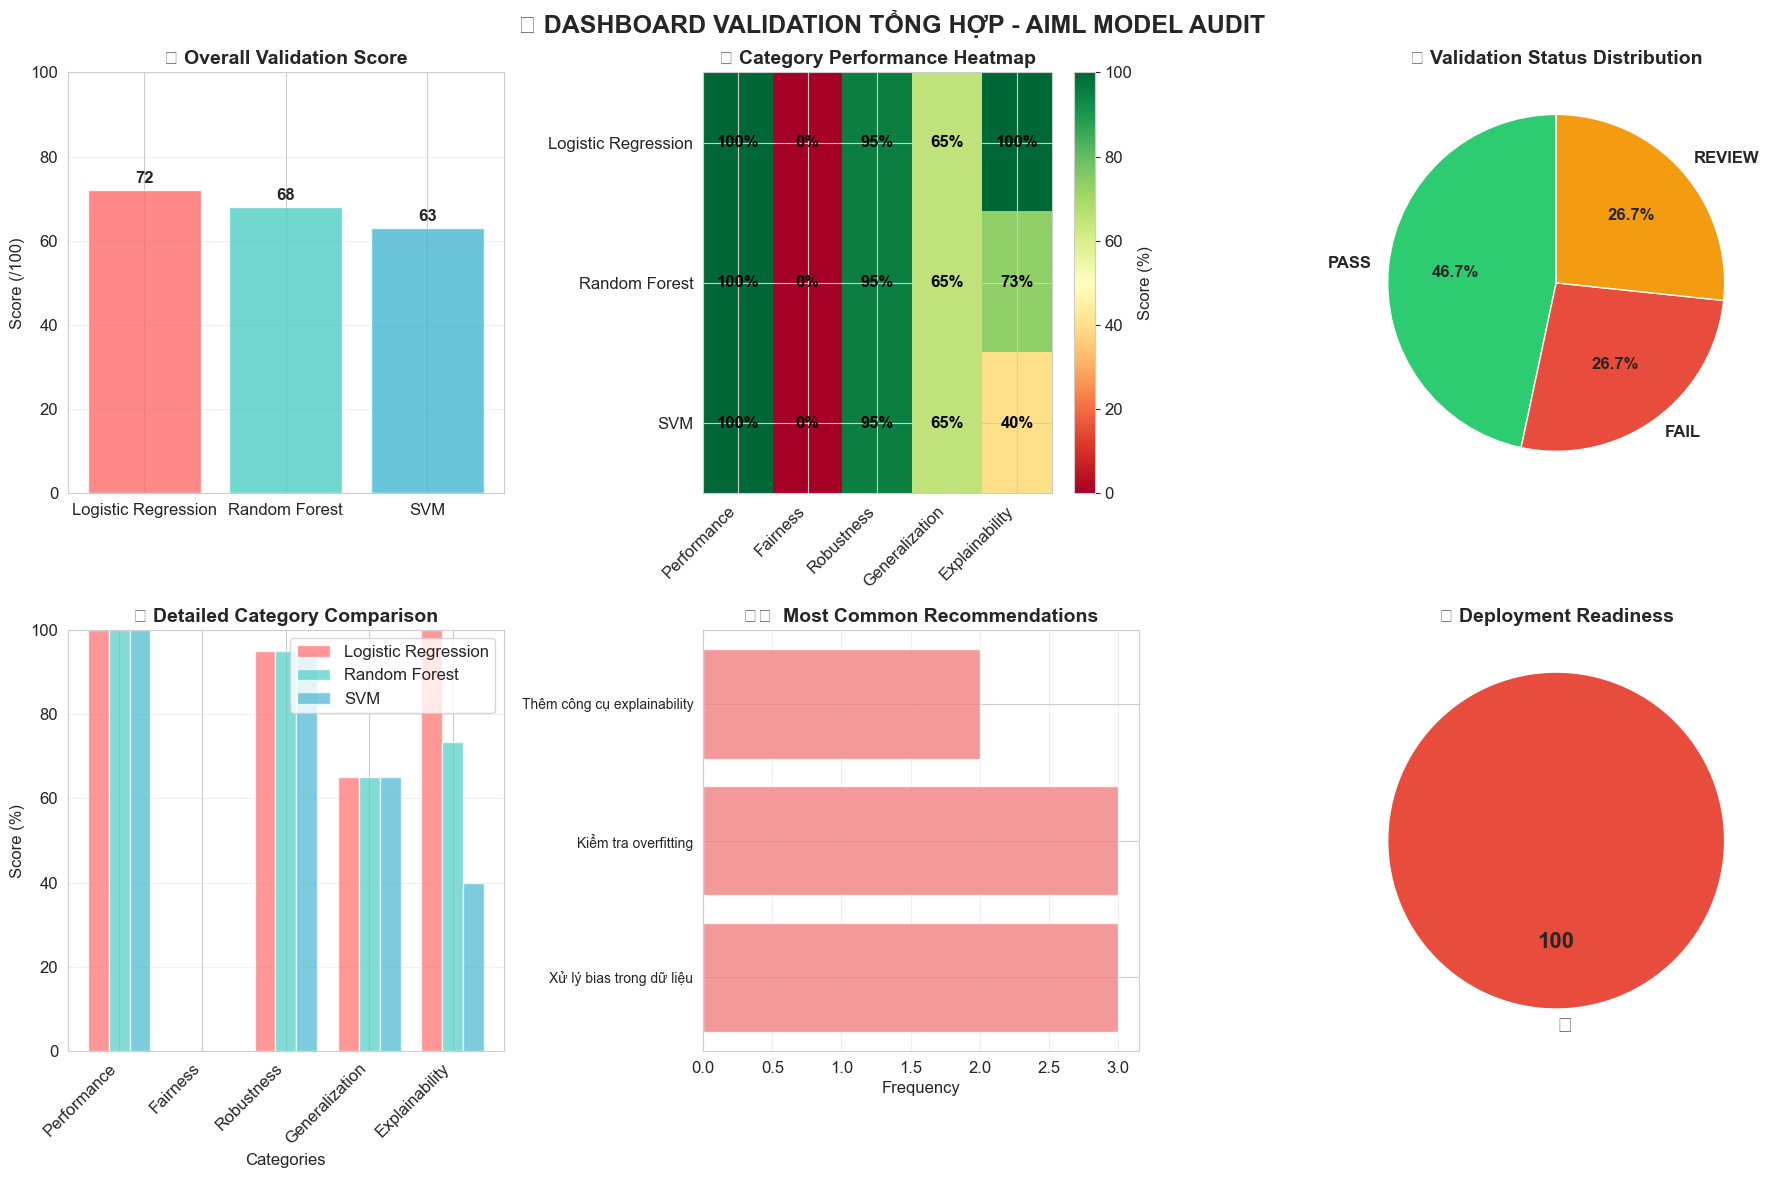


🎯 BÁO CÁO VALIDATION TỔNG HỢP - COMPREHENSIVE MODEL AUDIT REPORT

🔍 MÔ HÌNH: LOGISTIC REGRESSION
   📊 Tổng điểm: 72/100 (72.0%)
   🚀 Trạng thái triển khai: ❌ NOT READY - Cần cải thiện
   📅 Ngày đánh giá: 2025-08-23 09:58:19
   📈 Chi tiết từng danh mục:
     • Performance: 25/25 (100.0%) ✅
     • Fairness: 0/20 (0.0%) ❌
     • Robustness: 19/20 (95.0%) ✅
     • Generalization: 13/20 (65.0%) ⚠️
     • Explainability: 15/15 (100.0%) ✅
   💡 Đề xuất cải thiện:
     1. Xử lý bias trong dữ liệu
     2. Kiểm tra overfitting

🔍 MÔ HÌNH: RANDOM FOREST
   📊 Tổng điểm: 68/100 (68.0%)
   🚀 Trạng thái triển khai: ❌ NOT READY - Cần cải thiện
   📅 Ngày đánh giá: 2025-08-23 09:58:19
   📈 Chi tiết từng danh mục:
     • Performance: 25/25 (100.0%) ✅
     • Fairness: 0/20 (0.0%) ❌
     • Robustness: 19/20 (95.0%) ✅
     • Generalization: 13/20 (65.0%) ⚠️
     • Explainability: 11/15 (73.3%) ⚠️
   💡 Đề xuất cải thiện:
     1. Xử lý bias trong dữ liệu
     2. Kiểm tra overfitting
     3. Thêm công cụ expla

In [31]:
# Final Comprehensive Validation Dashboard
def create_validation_dashboard(validation_checklist):
    """Tạo dashboard tổng hợp cho validation results"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🎯 DASHBOARD VALIDATION TỔNG HỢP - AIML MODEL AUDIT', 
                 fontsize=18, fontweight='bold')
    
    model_names = list(validation_checklist.keys())
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # Plot 1: Overall Scores
    overall_scores = [checklist['overall_score'] for checklist in validation_checklist.values()]
    bars1 = axes[0, 0].bar(range(len(model_names)), overall_scores, color=colors, alpha=0.8)
    axes[0, 0].set_title('📊 Overall Validation Score', fontweight='bold', fontsize=14)
    axes[0, 0].set_ylabel('Score (/100)')
    axes[0, 0].set_xticks(range(len(model_names)))
    axes[0, 0].set_xticklabels([name.replace('_', ' ') for name in model_names])
    axes[0, 0].set_ylim(0, 100)
    axes[0, 0].grid(True, axis='y', alpha=0.3)
    
    # Add score labels
    for i, (bar, score) in enumerate(zip(bars1, overall_scores)):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                       f'{score}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Plot 2: Category Scores Heatmap
    categories = ['performance', 'fairness', 'robustness', 'generalization', 'explainability']
    category_labels = ['Performance', 'Fairness', 'Robustness', 'Generalization', 'Explainability']
    
    heatmap_data = []
    for model_name in model_names:
        model_scores = []
        for category in categories:
            score = validation_checklist[model_name]['categories'][category]['percentage']
            model_scores.append(score)
        heatmap_data.append(model_scores)
    
    heatmap_data = np.array(heatmap_data)
    im = axes[0, 1].imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
    axes[0, 1].set_title('🔥 Category Performance Heatmap', fontweight='bold', fontsize=14)
    axes[0, 1].set_xticks(range(len(categories)))
    axes[0, 1].set_xticklabels(category_labels, rotation=45, ha='right')
    axes[0, 1].set_yticks(range(len(model_names)))
    axes[0, 1].set_yticklabels([name.replace('_', ' ') for name in model_names])
    
    # Add percentage labels
    for i in range(len(model_names)):
        for j in range(len(categories)):
            text = axes[0, 1].text(j, i, f'{heatmap_data[i, j]:.0f}%',
                                 ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=axes[0, 1], label='Score (%)')
    
    # Plot 3: Status Distribution
    status_counts = {}
    for checklist in validation_checklist.values():
        for category_data in checklist['categories'].values():
            status = category_data['status']
            status_counts[status] = status_counts.get(status, 0) + 1
    
    status_colors = {'PASS': '#2ECC71', 'REVIEW': '#F39C12', 'FAIL': '#E74C3C'}
    statuses = list(status_counts.keys())
    counts = list(status_counts.values())
    pie_colors = [status_colors.get(status, '#95A5A6') for status in statuses]
    
    axes[0, 2].pie(counts, labels=statuses, colors=pie_colors, autopct='%1.1f%%', 
                  startangle=90, textprops={'fontweight': 'bold'})
    axes[0, 2].set_title('📈 Validation Status Distribution', fontweight='bold', fontsize=14)
    
    # Plot 4: Performance Comparison (Radar Chart simulation)
    categories_for_radar = category_labels
    
    # Create a simple bar chart instead of radar
    x_pos = np.arange(len(categories))
    width = 0.25
    
    for i, (model_name, checklist) in enumerate(validation_checklist.items()):
        scores = [checklist['categories'][cat]['percentage'] for cat in categories]
        axes[1, 0].bar(x_pos + i*width, scores, width, 
                      label=model_name.replace('_', ' '), 
                      color=colors[i], alpha=0.7)
    
    axes[1, 0].set_title('📊 Detailed Category Comparison', fontweight='bold', fontsize=14)
    axes[1, 0].set_xlabel('Categories')
    axes[1, 0].set_ylabel('Score (%)')
    axes[1, 0].set_xticks(x_pos + width)
    axes[1, 0].set_xticklabels(category_labels, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(True, axis='y', alpha=0.3)
    axes[1, 0].set_ylim(0, 100)
    
    # Plot 5: Recommendations Summary
    all_recommendations = []
    for checklist in validation_checklist.values():
        all_recommendations.extend(checklist['recommendations'])
    
    # Count recommendation frequencies
    rec_counts = {}
    for rec in all_recommendations:
        rec_counts[rec] = rec_counts.get(rec, 0) + 1
    
    if rec_counts:
        rec_labels = list(rec_counts.keys())
        rec_values = list(rec_counts.values())
        
        axes[1, 1].barh(range(len(rec_labels)), rec_values, color='lightcoral', alpha=0.8)
        axes[1, 1].set_yticks(range(len(rec_labels)))
        axes[1, 1].set_yticklabels([label[:30] + '...' if len(label) > 30 else label 
                                   for label in rec_labels], fontsize=10)
        axes[1, 1].set_title('⚠️  Most Common Recommendations', fontweight='bold', fontsize=14)
        axes[1, 1].set_xlabel('Frequency')
        axes[1, 1].grid(True, axis='x', alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Recommendations\nAll Models Passed!', 
                       ha='center', va='center', fontsize=14, fontweight='bold')
        axes[1, 1].set_title('⚠️  Recommendations', fontweight='bold', fontsize=14)
    
    # Plot 6: Deployment Readiness
    deployment_status = {}
    for checklist in validation_checklist.values():
        status = checklist['deployment_recommendation'].split()[0]  # Get emoji part
        deployment_status[status] = deployment_status.get(status, 0) + 1
    
    status_labels = list(deployment_status.keys())
    status_values = list(deployment_status.values())
    status_colors_deploy = ['#2ECC71' if '✅' in label else '#F39C12' if '⚠️' in label else '#E74C3C' 
                           for label in status_labels]
    
    axes[1, 2].pie(status_values, labels=status_labels, colors=status_colors_deploy, 
                  autopct='%1.0f', startangle=90, textprops={'fontsize': 16, 'fontweight': 'bold'})
    axes[1, 2].set_title('🚀 Deployment Readiness', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive summary
    print("\n" + "="*80)
    print("🎯 BÁO CÁO VALIDATION TỔNG HỢP - COMPREHENSIVE MODEL AUDIT REPORT")
    print("="*80)
    
    for model_name, checklist in validation_checklist.items():
        print(f"\n🔍 MÔ HÌNH: {model_name.replace('_', ' ').upper()}")
        print(f"   📊 Tổng điểm: {checklist['overall_score']}/100 ({checklist['overall_percentage']:.1f}%)")
        print(f"   🚀 Trạng thái triển khai: {checklist['deployment_recommendation']}")
        print(f"   📅 Ngày đánh giá: {checklist['validation_date']}")
        
        print("   📈 Chi tiết từng danh mục:")
        for category, data in checklist['categories'].items():
            status_icon = "✅" if data['status'] == 'PASS' else "⚠️" if data['status'] == 'REVIEW' else "❌"
            print(f"     • {category.capitalize()}: {data['score']}/{data['max_score']} ({data['percentage']:.1f}%) {status_icon}")
        
        if checklist['recommendations']:
            print("   💡 Đề xuất cải thiện:")
            for i, rec in enumerate(checklist['recommendations'], 1):
                print(f"     {i}. {rec}")
        else:
            print("   🏆 Không có đề xuất - Mô hình đạt chuẩn!")
    
    print(f"\n" + "="*80)
    print("📋 KẾT LUẬN TỔNG QUÁT:")
    
    # Overall statistics
    avg_score = np.mean([c['overall_score'] for c in validation_checklist.values()])
    best_model = max(validation_checklist.items(), key=lambda x: x[1]['overall_score'])
    ready_models = sum(1 for c in validation_checklist.values() if '✅' in c['deployment_recommendation'])
    
    print(f"   • Điểm trung bình: {avg_score:.1f}/100")
    print(f"   • Mô hình tốt nhất: {best_model[0].replace('_', ' ')} ({best_model[1]['overall_score']}/100)")
    print(f"   • Số mô hình sẵn sàng triển khai: {ready_models}/{len(validation_checklist)}")
    
    if ready_models == 0:
        print("   ⚠️  KHUYẾN NGHỊ: Tất cả mô hình cần cải thiện trước khi triển khai!")
    elif ready_models < len(validation_checklist):
        print(f"   ⚠️  KHUYẾN NGHỊ: {len(validation_checklist) - ready_models} mô hình cần được cải thiện!")
    else:
        print("   🏆 TẤT CẢ MÔ HÌNH ĐẠT CHUẨN TRIỂN KHAI!")
    
    print("="*80)

# Create validation dashboard
create_validation_dashboard(validation_checklist)